This program is designed by zwbai, 2024.1.1

This example implements the experiments on citation networks from the paper:


In [3]:
# [1]本节是一个判断节，用于判断是否要跳过部分代码，由3部分组成[判断，链接，锚点]
# This is a section to judge that if or not to jump some code, consisting of three parts [judgement, link, anchor].
# 如果要执行跳过，程序会抛出一个警告， 然后执行jump就能跳转到指定行
needs_jump = False
if needs_jump:
    raise UserWarning("Finished: jump to target")
else:
    print("Ignore jump section and continue")

Ignore jump section and continue


[jump to target2](#target_section1)
### Continue run code. [1]

<a id='target_section1'></a>
### Anchor point to continue run code [1]

# 1. Function part

## 1.1 environment settiong and function importing

In [4]:
import dill
import lmdb
import copy
import pickle
import shutil
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from scipy import io
from copy import deepcopy
from spektral.data import Dataset, Graph
from ocpmodels.datasets import LmdbDataset
from sklearn.model_selection import train_test_split

from ocpre import *  # loading functions related with the program. 本项目相关的基础函数写在ocpre中

## 1.3 folder path

This program need to define many variable name for value name and file (or folder) name, so we agree as follows,
'_l' or '_d' suffix used to define variable but '_list' and '_dict' uesd to define file name.

The string '_copy' and '_cal' also usually used as the suffix of the dictionary path name  

In this program, lists and dictionaries are  parallel use. For the sake of format uniformity, we usually use '1000' as the start of the key of the dictionary. 

In [5]:
folder_path_all = "/media/zwbai/DATA/dft/alloy_copy/"  # Data storage folder, including output and input folders
output_path = (folder_path_all + "output/")  
# 输出文件夹，一般存储用来进一步的计算的文件。 Input folder stores files for further DFT calculations.
input_path = (folder_path_all + "input/")  
# 输入文件夹，一般是已经计算完成的文件。 Output folder stores files that is result of DFT calculations.
data_path = (folder_path_all + "vasp_cal/")  # 用于机器学习的数据的文件 Folder store data for ML

exist_folder(folder_path_all, is_creat=False)  # Need to create in advance
exist_folder(input_path, is_creat=False)  # Need to create in advance
exist_folder(output_path, is_creat=True)  # Don't need to creat in advance
exist_folder(data_path, is_creat=True)  # Don't need to creat in advance


# input
# They are mostly calculation result, so their names are ended with '_copy' or '_cal'
# 计算结果多以copy或者cal结尾
CONT_path = input_path + "Ex42-Cu-Bulk/"
Cu_bulk_copy = input_path + "Cu_bulk_copy/"
Cu_slab_copy = input_path + "Cu_slab_copy"
refer_bulk_copy = input_path + "refer_bulk_copy"  # i
refer_slab_copy = input_path + "refer_slab_copy"  # i

alloy_slab_copy = input_path + "alloy_slab_copy"

Cu_slab4_copy = input_path + "Cu_slab4_copy"
one_atom_copy = input_path + "one_atom_copy"
nostrain_molecule_copy = input_path + "nostrain_molecule_copy"
strain_adslab_copy = input_path + "strain_adslab_copy"  # i
dos_cal = input_path + "dos_cal"  # i


# output
Cu_bulk_path = output_path + "Cu_bulk"  #
Cu_slab_path = output_path + "Cu_slab"

refer_bulk_folder = output_path + "refer_bulk"
refer_slab_folder = output_path + "refer_slab"
strain_alloy_slabs_folder = output_path + "alloy_slab"

Cu_slab4_folder = output_path + "Cu_slab4"
one_atom_folder = output_path + "one_atom"
nostrain_molecule_folder = output_path + "nostrain_molecule"
strain_adslab_folder = output_path + "strain_adslab"


# data
strain_value_dict = output_path + "strain_matrix_dict.pkl"
strain_value_list = output_path + "strain_matrix.npy"

ml_GNN_data_dict = output_path + "ml_GNN_data_dict.pkl"
pre_GNN_data_dict = output_path + "pre_GNN_data_dict.pkl"

lmdb_file_ml = output_path + "CuO2_strain_ml.lmdb"  # 本程序创建的部分
lmdb_file_all = output_path + "CuO2_strain_all.lmdb"  # 整合的所有数据
lmdb_file_train = output_path + "CuO2_strain_train.lmdb"  # 拆分的训练数据
lmdb_file_test = output_path + "CuO2_strain_test.lmdb"  # 拆分的测试数据
lmdb_file_pre = output_path + "CuO2_strain_pre.lmdb"  # 准备预测的数据

dos_data_file = output_path + "dos_data.pkl"
dos_energy_data_file = output_path + "dos_energy_data.pkl"

pack_data_files = [
    strain_value_dict,
    strain_value_list,
    ml_GNN_data_dict,
    pre_GNN_data_dict,
    lmdb_file_ml,
    lmdb_file_train,
    lmdb_file_test,
    dos_data_file,
    dos_energy_data_file,
]  # data for ML

folder '/media/zwbai/DATA/dft/alloy_copy/' exists
folder '/media/zwbai/DATA/dft/alloy_copy/input/' exists
folder '/media/zwbai/DATA/dft/alloy_copy/output/' exists
folder '/media/zwbai/DATA/dft/alloy_copy/vasp_cal/' exists


# 2. Initial cofiguration of bulk and slab

## 2.1 bulk

In [ ]:
bulk = int_bulk(CONT_path)
out_poscar(bulk, path=Cu_bulk_path)
print(bulk.get_cell())
print(bulk.get_positions())

3.636600176352717
Cell([[2.571464645163201, 0.0, 0.0], [1.2857323225816004, 2.226953707644869, 0.0], [0.0, 0.0, 6.2987762722568466]])
[[1.2857 0.7423 0.    ]
 [0.     1.4846 2.0996]
 [0.     0.     4.1992]]


In [ ]:
bulk = read_one_car(Cu_bulk_copy)
slab = vac_ext(bulk, vacuum_h=30.0, ads_layer=4)  # 多加4个原子并添加真空层
out_poscar(slab, path=Cu_slab_path)

In [ ]:
# 无应变的slab，优化计算结果在'./vasp_cala/Cu_slab_copy/CONTCAR'
slab_op = read_one_car(Cu_slab_copy)

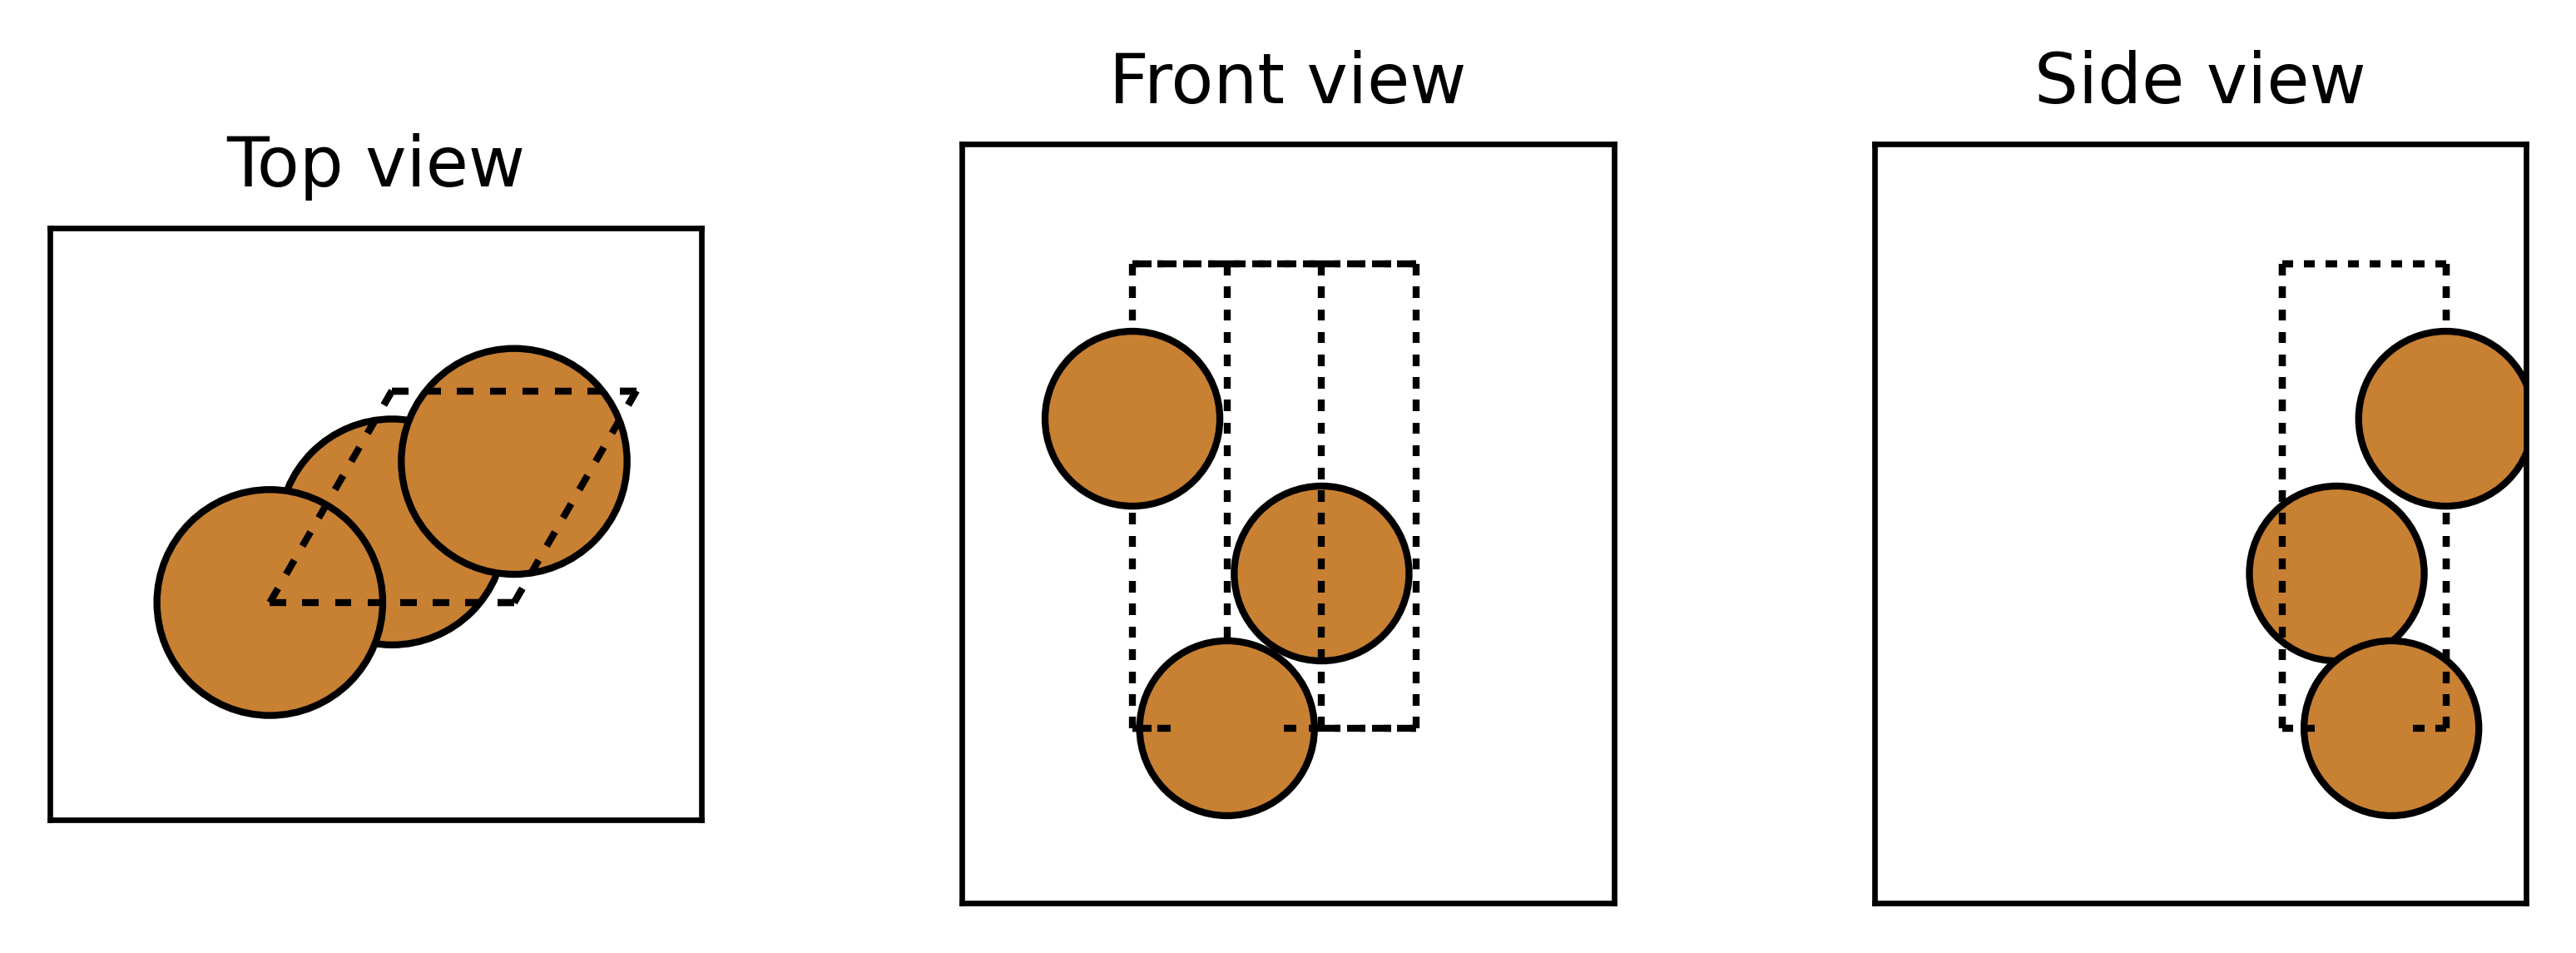

In [ ]:
plot_model(bulk)

## 2.2 slab

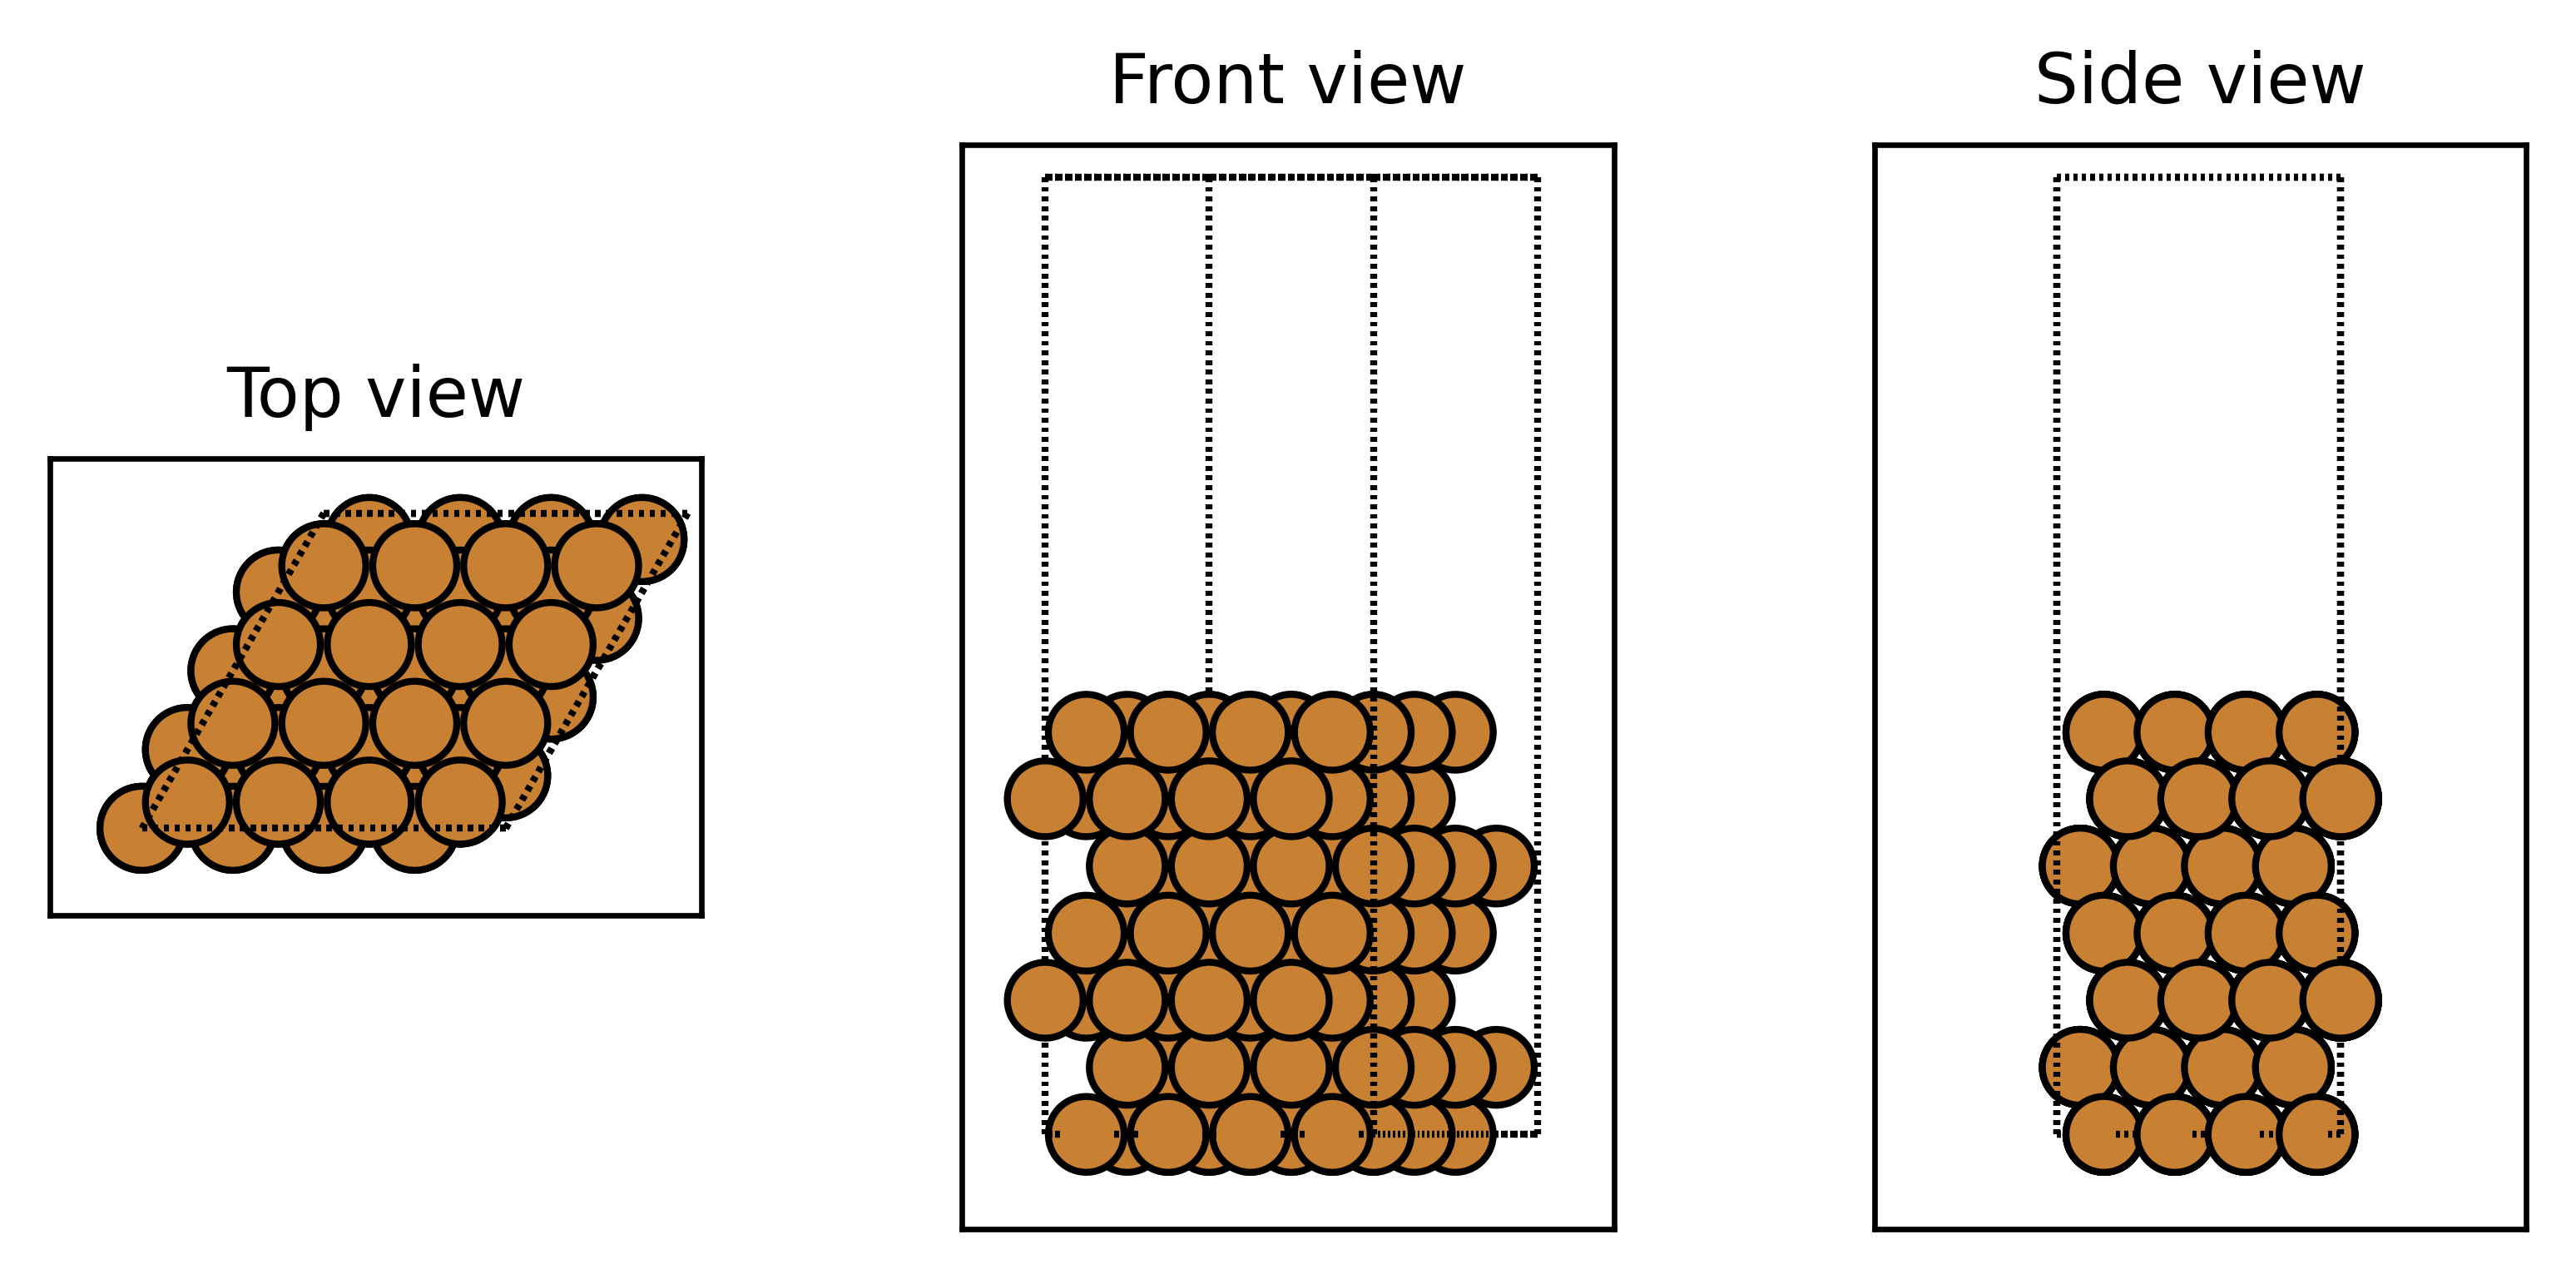

[FixAtoms(indices=[0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 14, 15, 16, 17, 18, 21, 22, 23, 24, 25, 28, 29, 30, 31, 32, 35, 36, 37, 38, 39, 42, 43, 44, 45, 46, 49, 50, 51, 52, 53, 56, 57, 58, 59, 60, 63, 64, 65, 66, 67, 70, 71, 72, 73, 74, 77, 78, 79, 80, 81, 84, 85, 86, 87, 88, 91, 92, 93, 94, 95, 98, 99, 100, 101, 102, 105, 106, 107, 108, 109]), FixCartesian(a=[5, 6, 12, 13, 19, 20, 26, 27, 33, 34, 40, 41, 47, 48, 54, 55, 61, 62, 68, 69, 75, 76, 82, 83, 89, 90, 96, 97, 103, 104, 110, 111], mask=[True, True, False])]


In [ ]:
slab_op.set_constraint()  # 清除约束
adslab = slab_op.copy()
adslab = adslab.repeat((4, 4, 1))
adslab = set_cons0(adslab)
plot_model(adslab)
print(adslab.constraints)
out_poscar(adslab, path=Cu_slab4_folder)  # 放大的基底

In [ ]:
exist_folder(Cu_slab4_copy)
adslab = read_one_car(Cu_slab4_copy)
adslab = set_cons1(adslab)
print(adslab.constraints)
print(adslab.get_tags())
print(len(adslab) - len(adslab.constraints[0].index))  # 有几个原子没有约束
# out_poscar(adslab1, path = './vasp_cala/Cu_slab4') # 放大的基底

folder '/media/zwbai/DATA/dft/alloy_copy/input/Cu_slab4_copy' exists
[FixAtoms(indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 98, 99, 100, 101, 102, 103, 105, 106, 107, 108, 109, 110])]
[ 0  0  0  0  0  1 -1  0  0  0  0  0  1 -1  0  0  0  0  0  1  2  0  0  0  0  0  1  2  0  0  0  0  0  1 -1  0  0  0  0  0  1  2  0  0  0  0  0  1  2  0  0  0  0
  0  1  2  0  0  0  0  0  1  2  0  0  0  0  0  1  2  0  0  0  0  0  1  2  0  0  0  0  0  1  2  0  0  0  0  0  1  2  0  0  0  0  0  1  2  0  0  0  0  0  1  2  0
  0  0  0  0  1  2]
13


## 2.3 alloy slabs

在Cu的基底中引入 Cr','Co', 'Pt' 原子实现合金化

In [ ]:
reatoms_str = ["Cr", "Pd", "Pt"]

In [ ]:
alloy_slab_l, alloy_slab_d = get_alloy_slab(adslab, reatoms_str)
len(alloy_slab_l)

21

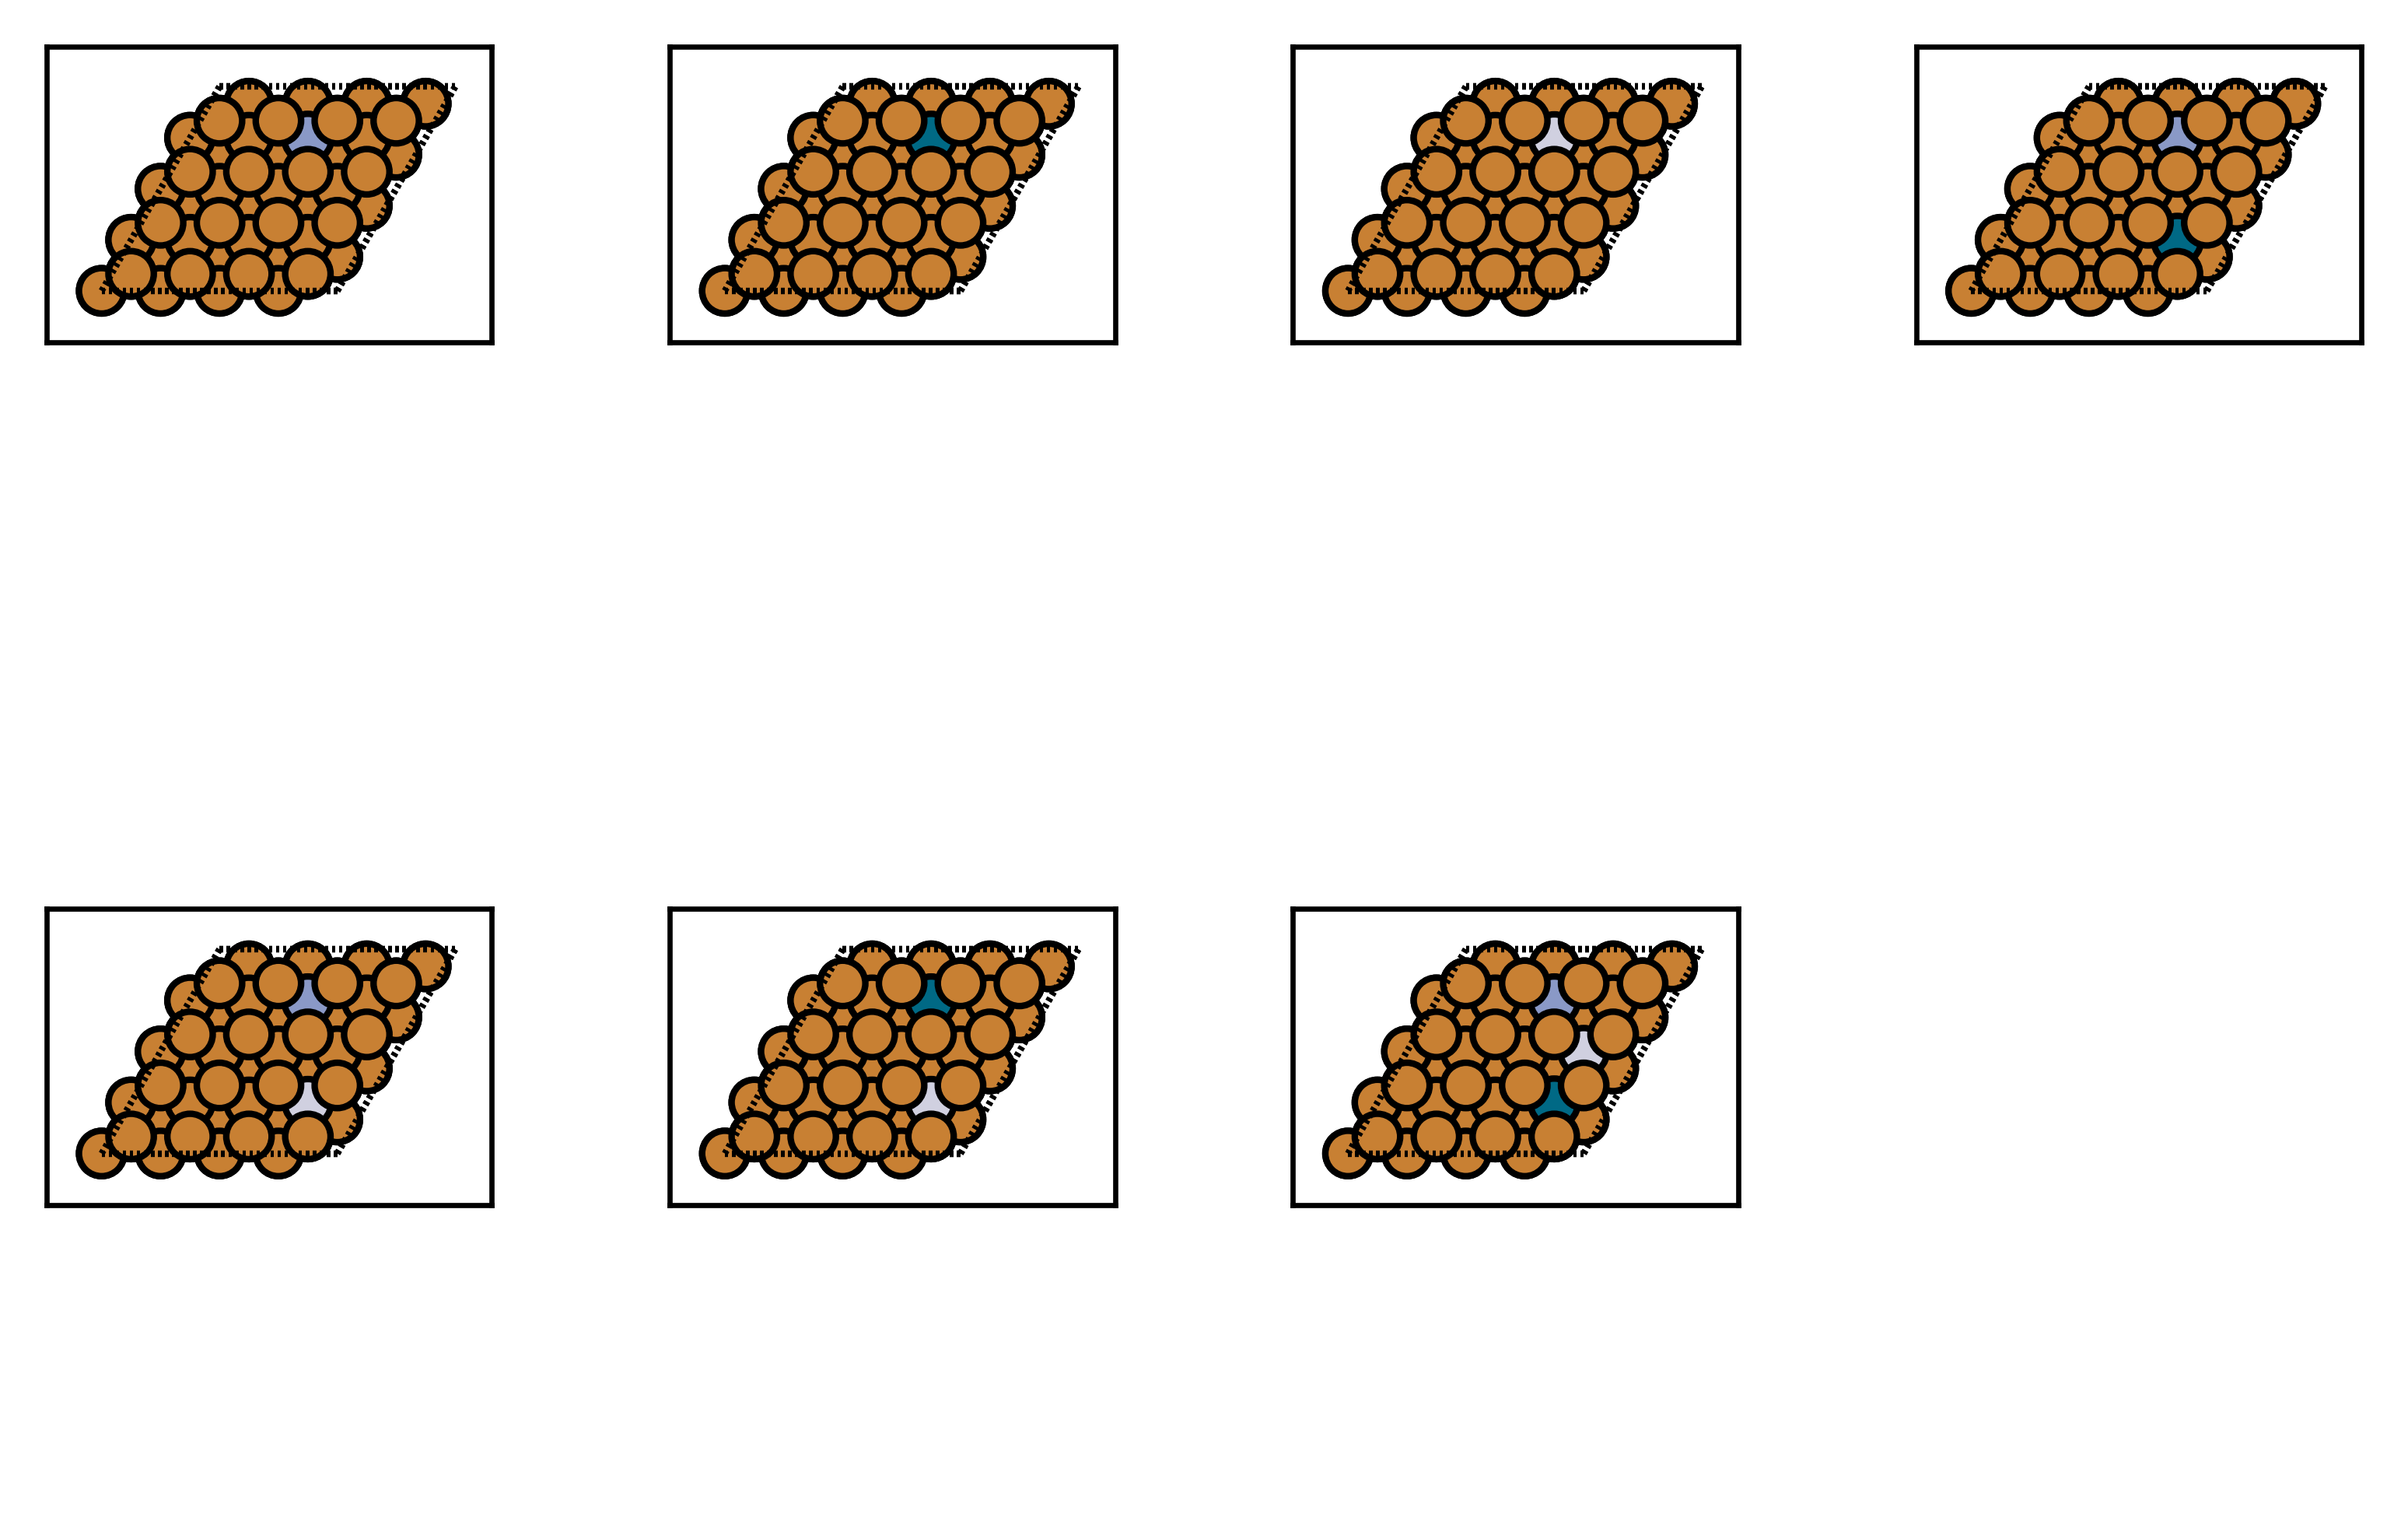

In [ ]:
plot_top(alloy_slab_l[::3], column=4, radii=0.75)

# 3. strain space 

## 3.1 strain value 

inherit: True
Input is dict


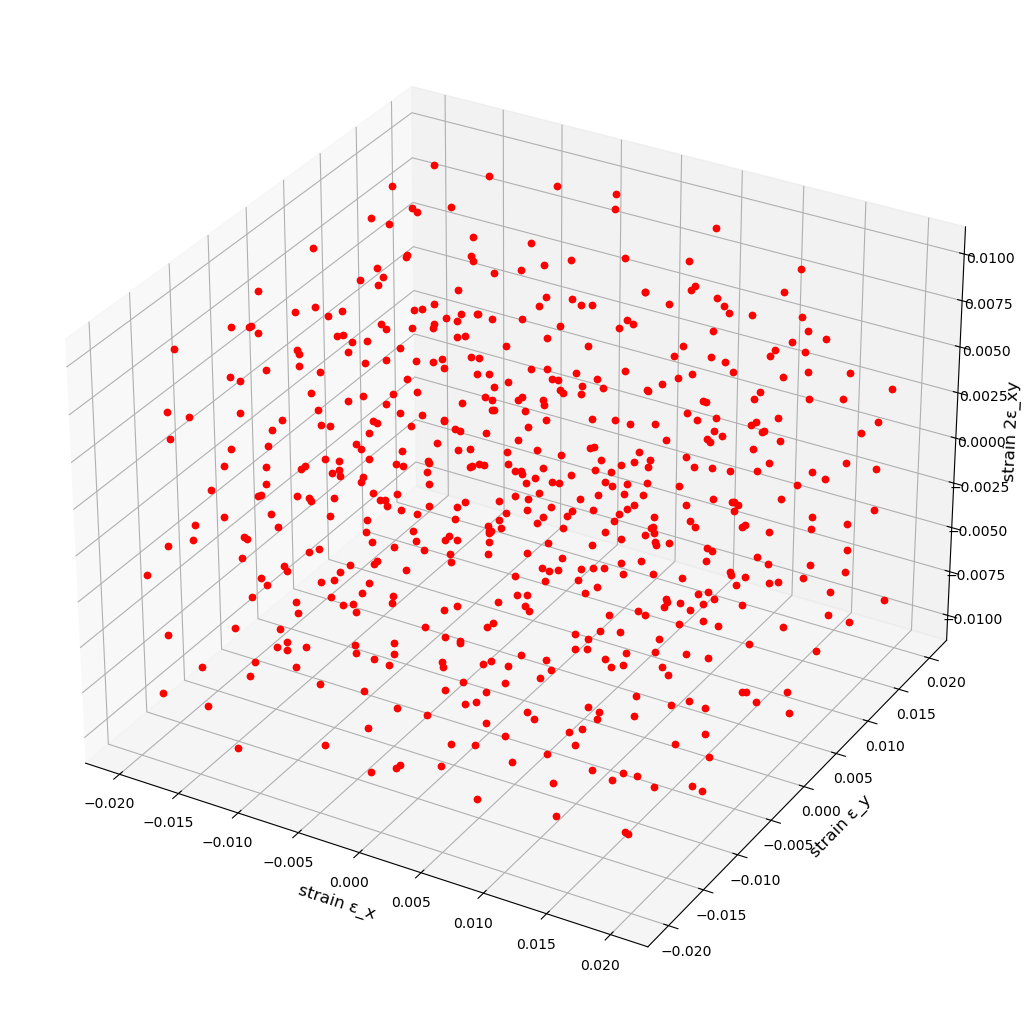

567

In [ ]:
inherit = True  # 是否用继承的坐标启动
print("inherit:", inherit)

num_strain = len(alloy_slab_l)  # 每个构型上的随机应变
random_select = len(alloy_slab_l)  # 从随机应变中挑选的个数，施加在构型上的实际应变
all_model_rotate = 27  # 所有的构型
max_strain = 0.02
strain_box = max_strain * np.array(
    [[-1, 1], [-1, 1], [-1, 1]]
)  # 应变范围 [ε_x ε_y 2ε_xy]
strain_box[2] = strain_box[2] / 2  #

strain_matrix, strain_matrix_d = generate_strain_matrix(
    num_strain,
    all_model_rotate,
    strain_box,
    random_select=random_select,
    inherit=inherit,
    dict_name=strain_value_dict,
    array_name=strain_value_list,
)
# %matplotlib auto
# plt.show(block=True)
test_dict_plot(strain_matrix_d)

len(strain_matrix_d.keys())

In [ ]:
strain_matrix.shape

(27, 21, 3)

## 3.2 strain bulk

In [ ]:
refer_bulk_l, refer_bulk_d = get_bulk_set(bulk, strain_matrix)

out_car_list(refer_bulk_l, path=refer_bulk_folder)

shutil.copy(strain_value_dict, refer_bulk_folder) # 对应的应变记录文件
shutil.copy(strain_value_list, refer_bulk_folder) # 对应的应变记录文件

'/media/zwbai/DATA/dft/alloy_copy/output/refer_bulk/strain_matrix.npy'

## 3.3 strain slab 

In [ ]:
exist_folder(refer_bulk_copy)  # 计算完成后，确保计算结果存在
# 复制CONTCAR文件到目标目录，执行操作，并改名为POSCAR
# 该方法直接从优化后的bulk创建了slab
poscar_files = copy_contcar(refer_bulk_copy, refer_slab_folder, func=operate)

folder '/media/zwbai/DATA/dft/alloy_copy/input/refer_bulk_copy' exists


get model from bulk to slab after calculation completed.

In [ ]:
exist_folder(refer_slab_copy)
strain_slabs_l, strain_slabs_d = read_cars(refer_slab_copy)  # 有应变的基底

folder '/media/zwbai/DATA/dft/alloy_copy/input/refer_slab_copy' exists
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020'])
1st dict_

In [ ]:
strain_slabs_l2, strain_slabs_d2 = slab2slabs(strain_slabs_l)
strain_alloy_slabs_l, strain_alloy_slabs_d = get_strain_alloy_slabs(alloy_slab_l, strain_slabs_l2)
out_car_list(strain_alloy_slabs_l, path=strain_alloy_slabs_folder)

In [ ]:
strain_allpy_slabs_l2, strain_allpy_slabs_d2 = read_cars(alloy_slab_copy)  # 有应变的基底

1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '

# 4. Adsorbed molecule

## 4.1 atom positions

In [ ]:
top3d_index = [
    [10, 11, 14, 15],
    [10, 11, 14, 7],
    [10, 11, 14, 13],
]  # 重要 是三种旋转坐标的参考原子在顶层的序号

top3d = get_top3d_rotate(adslab, top3d_index) # 顶层序号转为实际序号
top3d

[[76, 83, 104, 111], [76, 83, 104, 55], [76, 83, 104, 97]]

[ 9.0001  5.1962 14.4157]
[ 9.643   6.3097 14.1677]
[10.2859  5.9385 14.1169]
[11.5716  6.6809 14.1171]


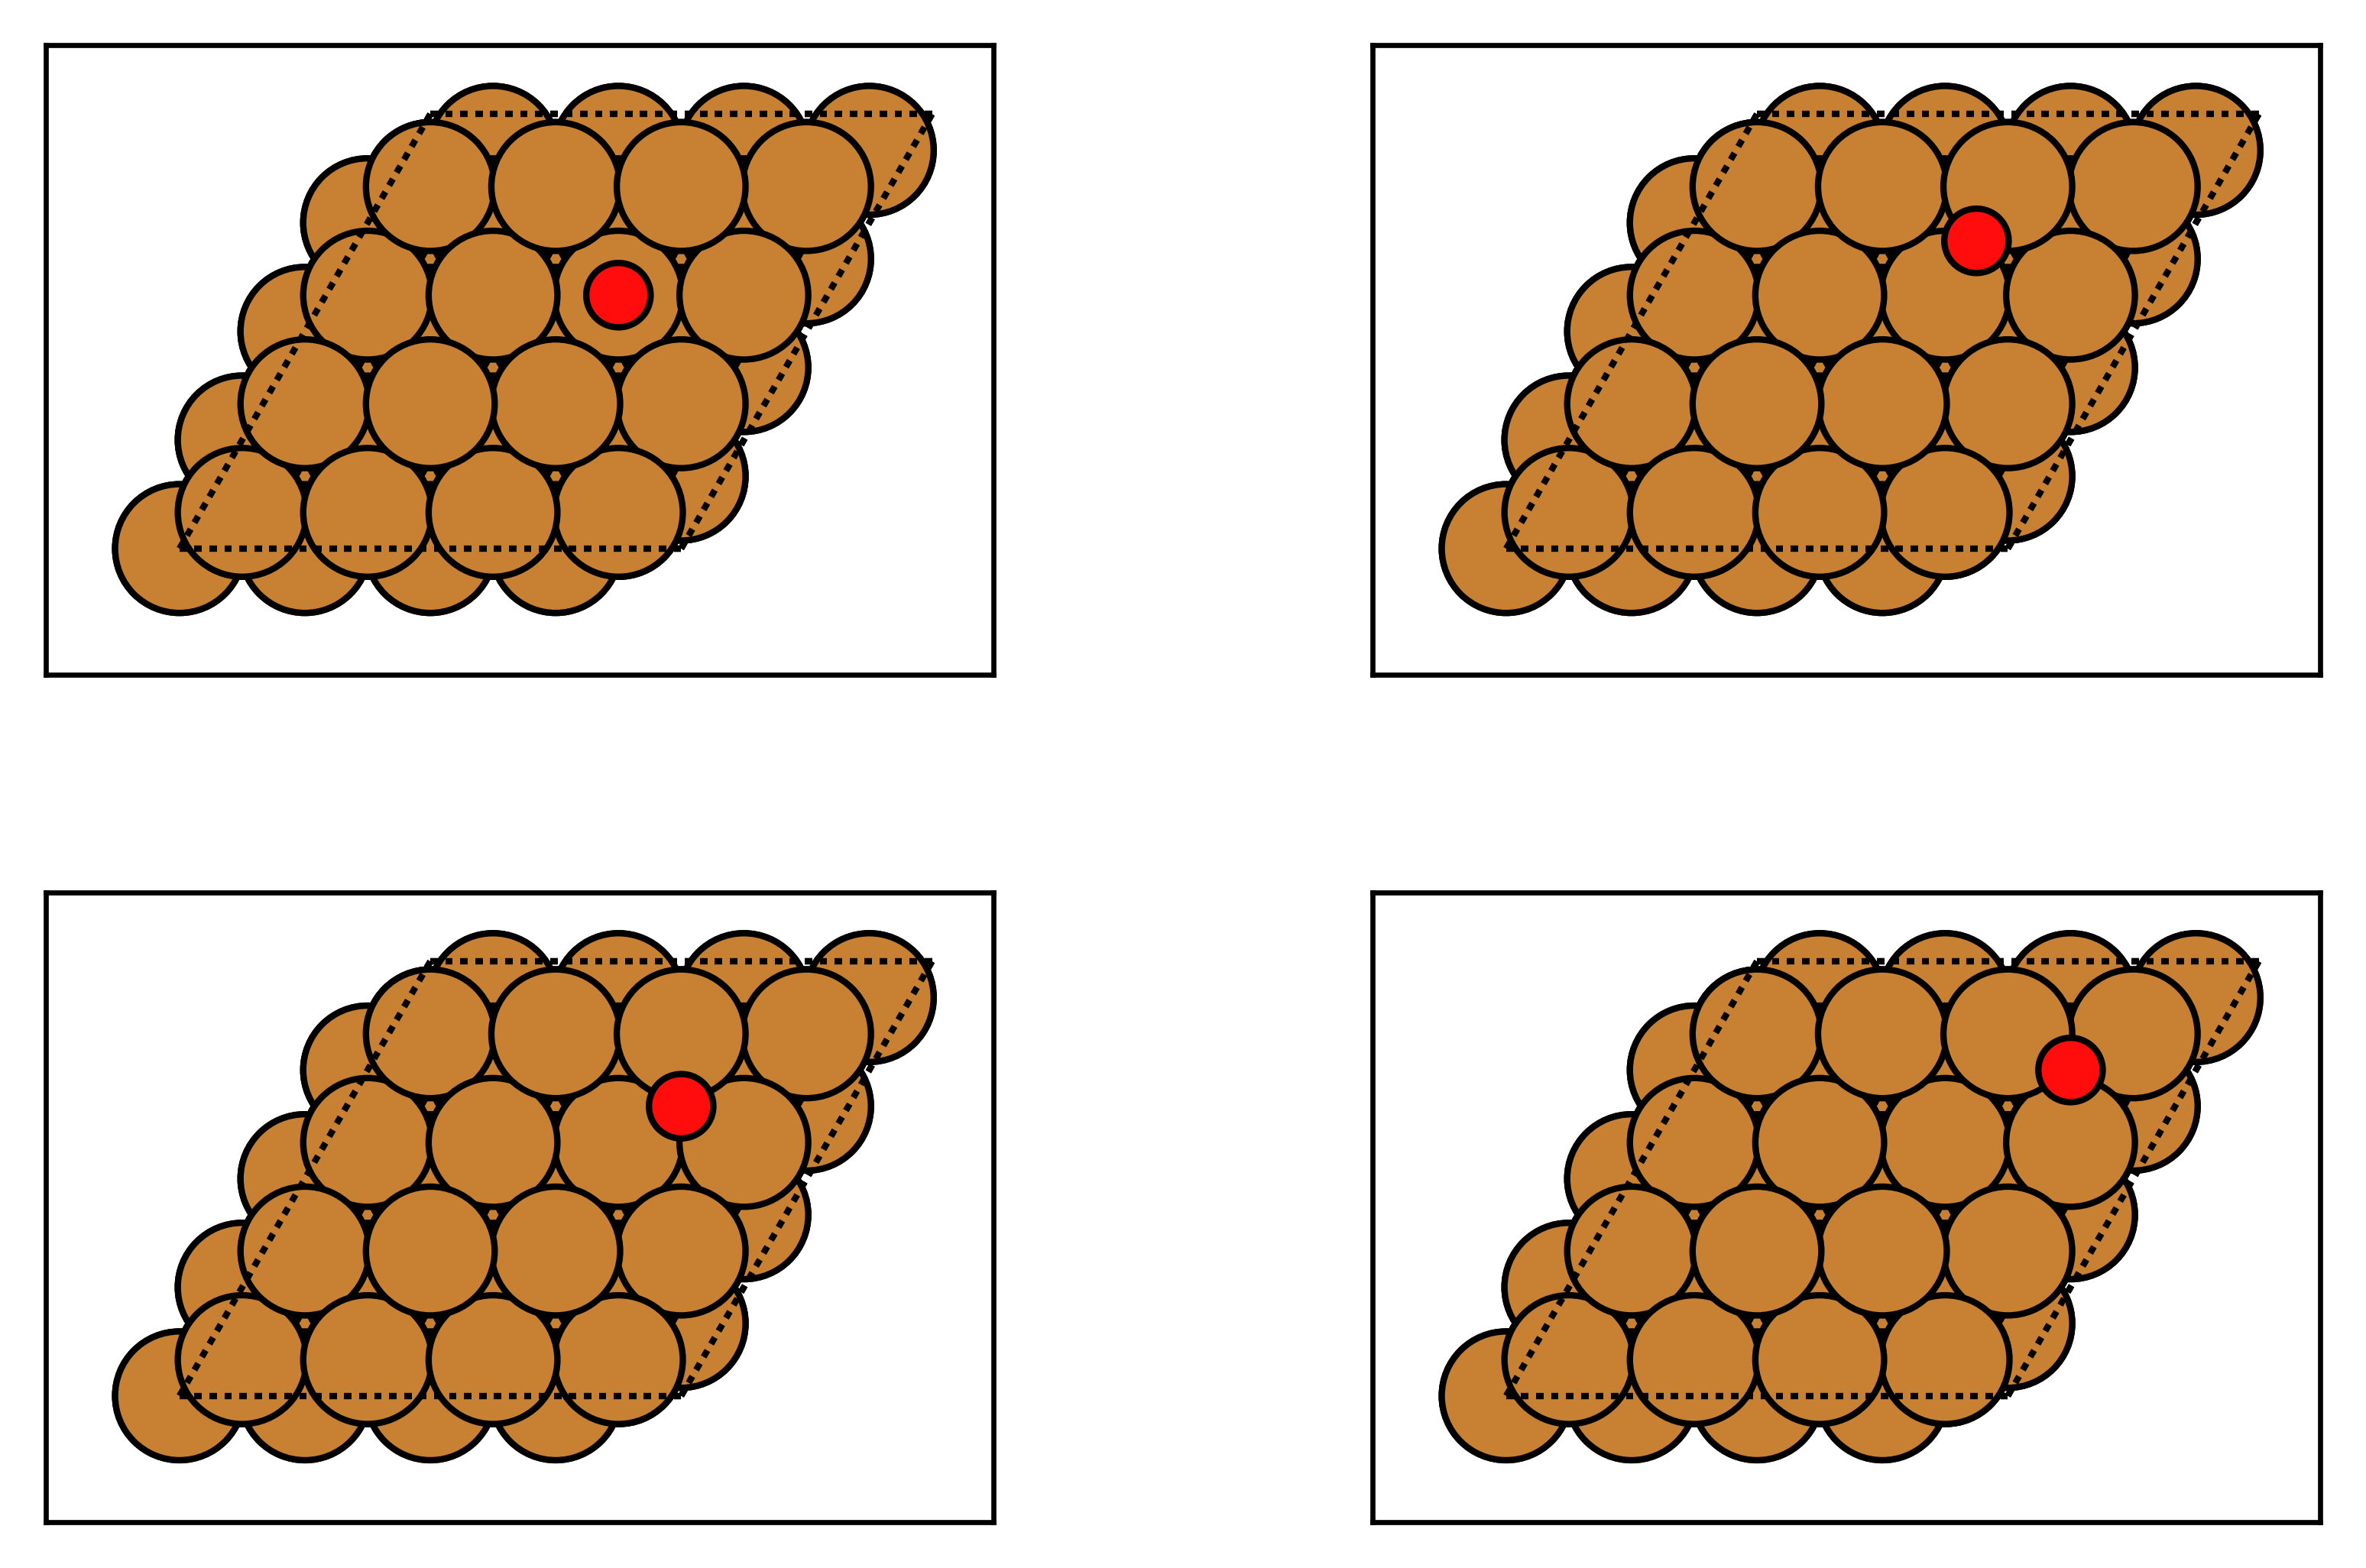

In [ ]:
order = ["top_0", "bri_12", "hol_012", "hol_123"]
atom_model_l, atom_model_d = get_atom_adsmodel(adslab, top3d[0], order=order)
plot_top(atom_model_l, column=2)
# folder_path = "./vasp_cala/one_atoms/"
out_poscar(atom_model_d, path=one_atom_folder)  # 新的单原子构型

1st dict_keys(['bri_12', 'hol_012', 'hol_123', 'top_0'])


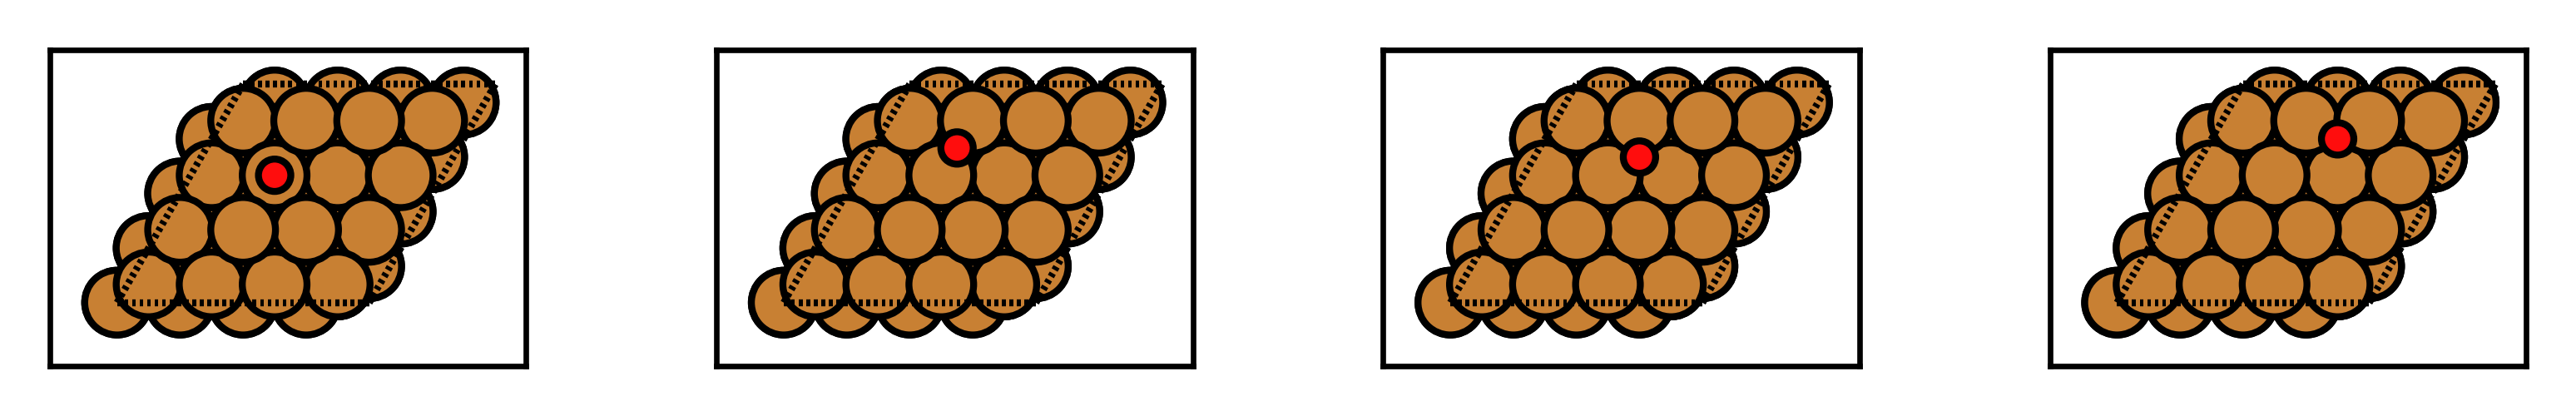

In [ ]:
one_atoms_l, one_atoms_dict = read_car(one_atom_copy, car="CONTCAR")  # car = 'CONTCAR'
one_atoms_l = [one_atoms_dict[i] for i in order]
plot_top(one_atoms_l, column=4)

In [ ]:
[
    one_atoms_l[i].get_positions()[-1, -1] for i in range(len(one_atoms_l))
]  # 单原子z方向的高度

[14.308458547612775, 13.890649479568673, 13.755736412769938, 13.76762035462312]

## 4.2 molecule positions

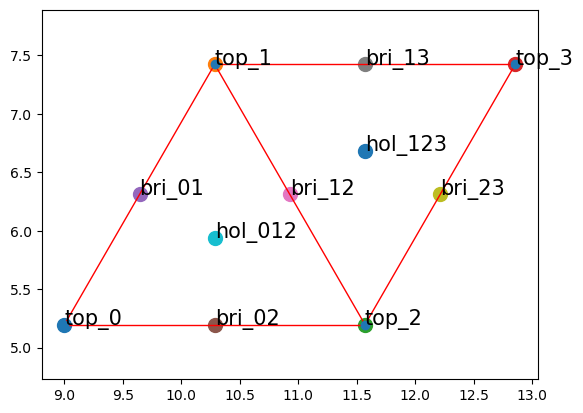

In [ ]:
mel_d = get_dic(adslab, one_atoms_l)  # 每个点的坐标
molecule_name = [
    ["top_0", "top_1"],  # 0-2
    ["top_0", "bri_12"],  # 3-5
    ["top_0", "hol_123"],  # shear2 6-8
    ["top_0", "hol_012"],  # 9-11
    ["hol_012", "bri_23"],  # shear 4 12-14
    ["hol_123", "bri_02"],  # shear2 5 15-17
    ["hol_012", "hol_123"],  # 18-20
    ["bri_02", "bri_13"],  # shear 7 21-23
    ["bri_02", "bri_12"],  # 24-26
    # ["hol_012", "hol_012"],  # 27-29 待选
    # ["hol_123", "hol_123"],  # 30-32 待选
]  # 吸附分子的两个原子的吸附位置
mol = np.zeros([len(molecule_name), 2, 3])  # 储存三维点坐标
for i in range(len(molecule_name)):
    mol_o2 = np.array([mel_d[molecule_name[i][0]], mel_d[molecule_name[i][1]]])
    mol[i] = mol_o2

In [ ]:
molecule_model = get_molecule_adslab(adslab, mol)

[14.3085 14.3085]
[14.3085 13.8906]
[14.3085 13.7676]
[14.3085 13.7557]
[13.7557 13.8906]
[13.7676 13.8906]
[13.7557 13.7676]
[13.8906 13.8906]
[13.8906 13.8906]


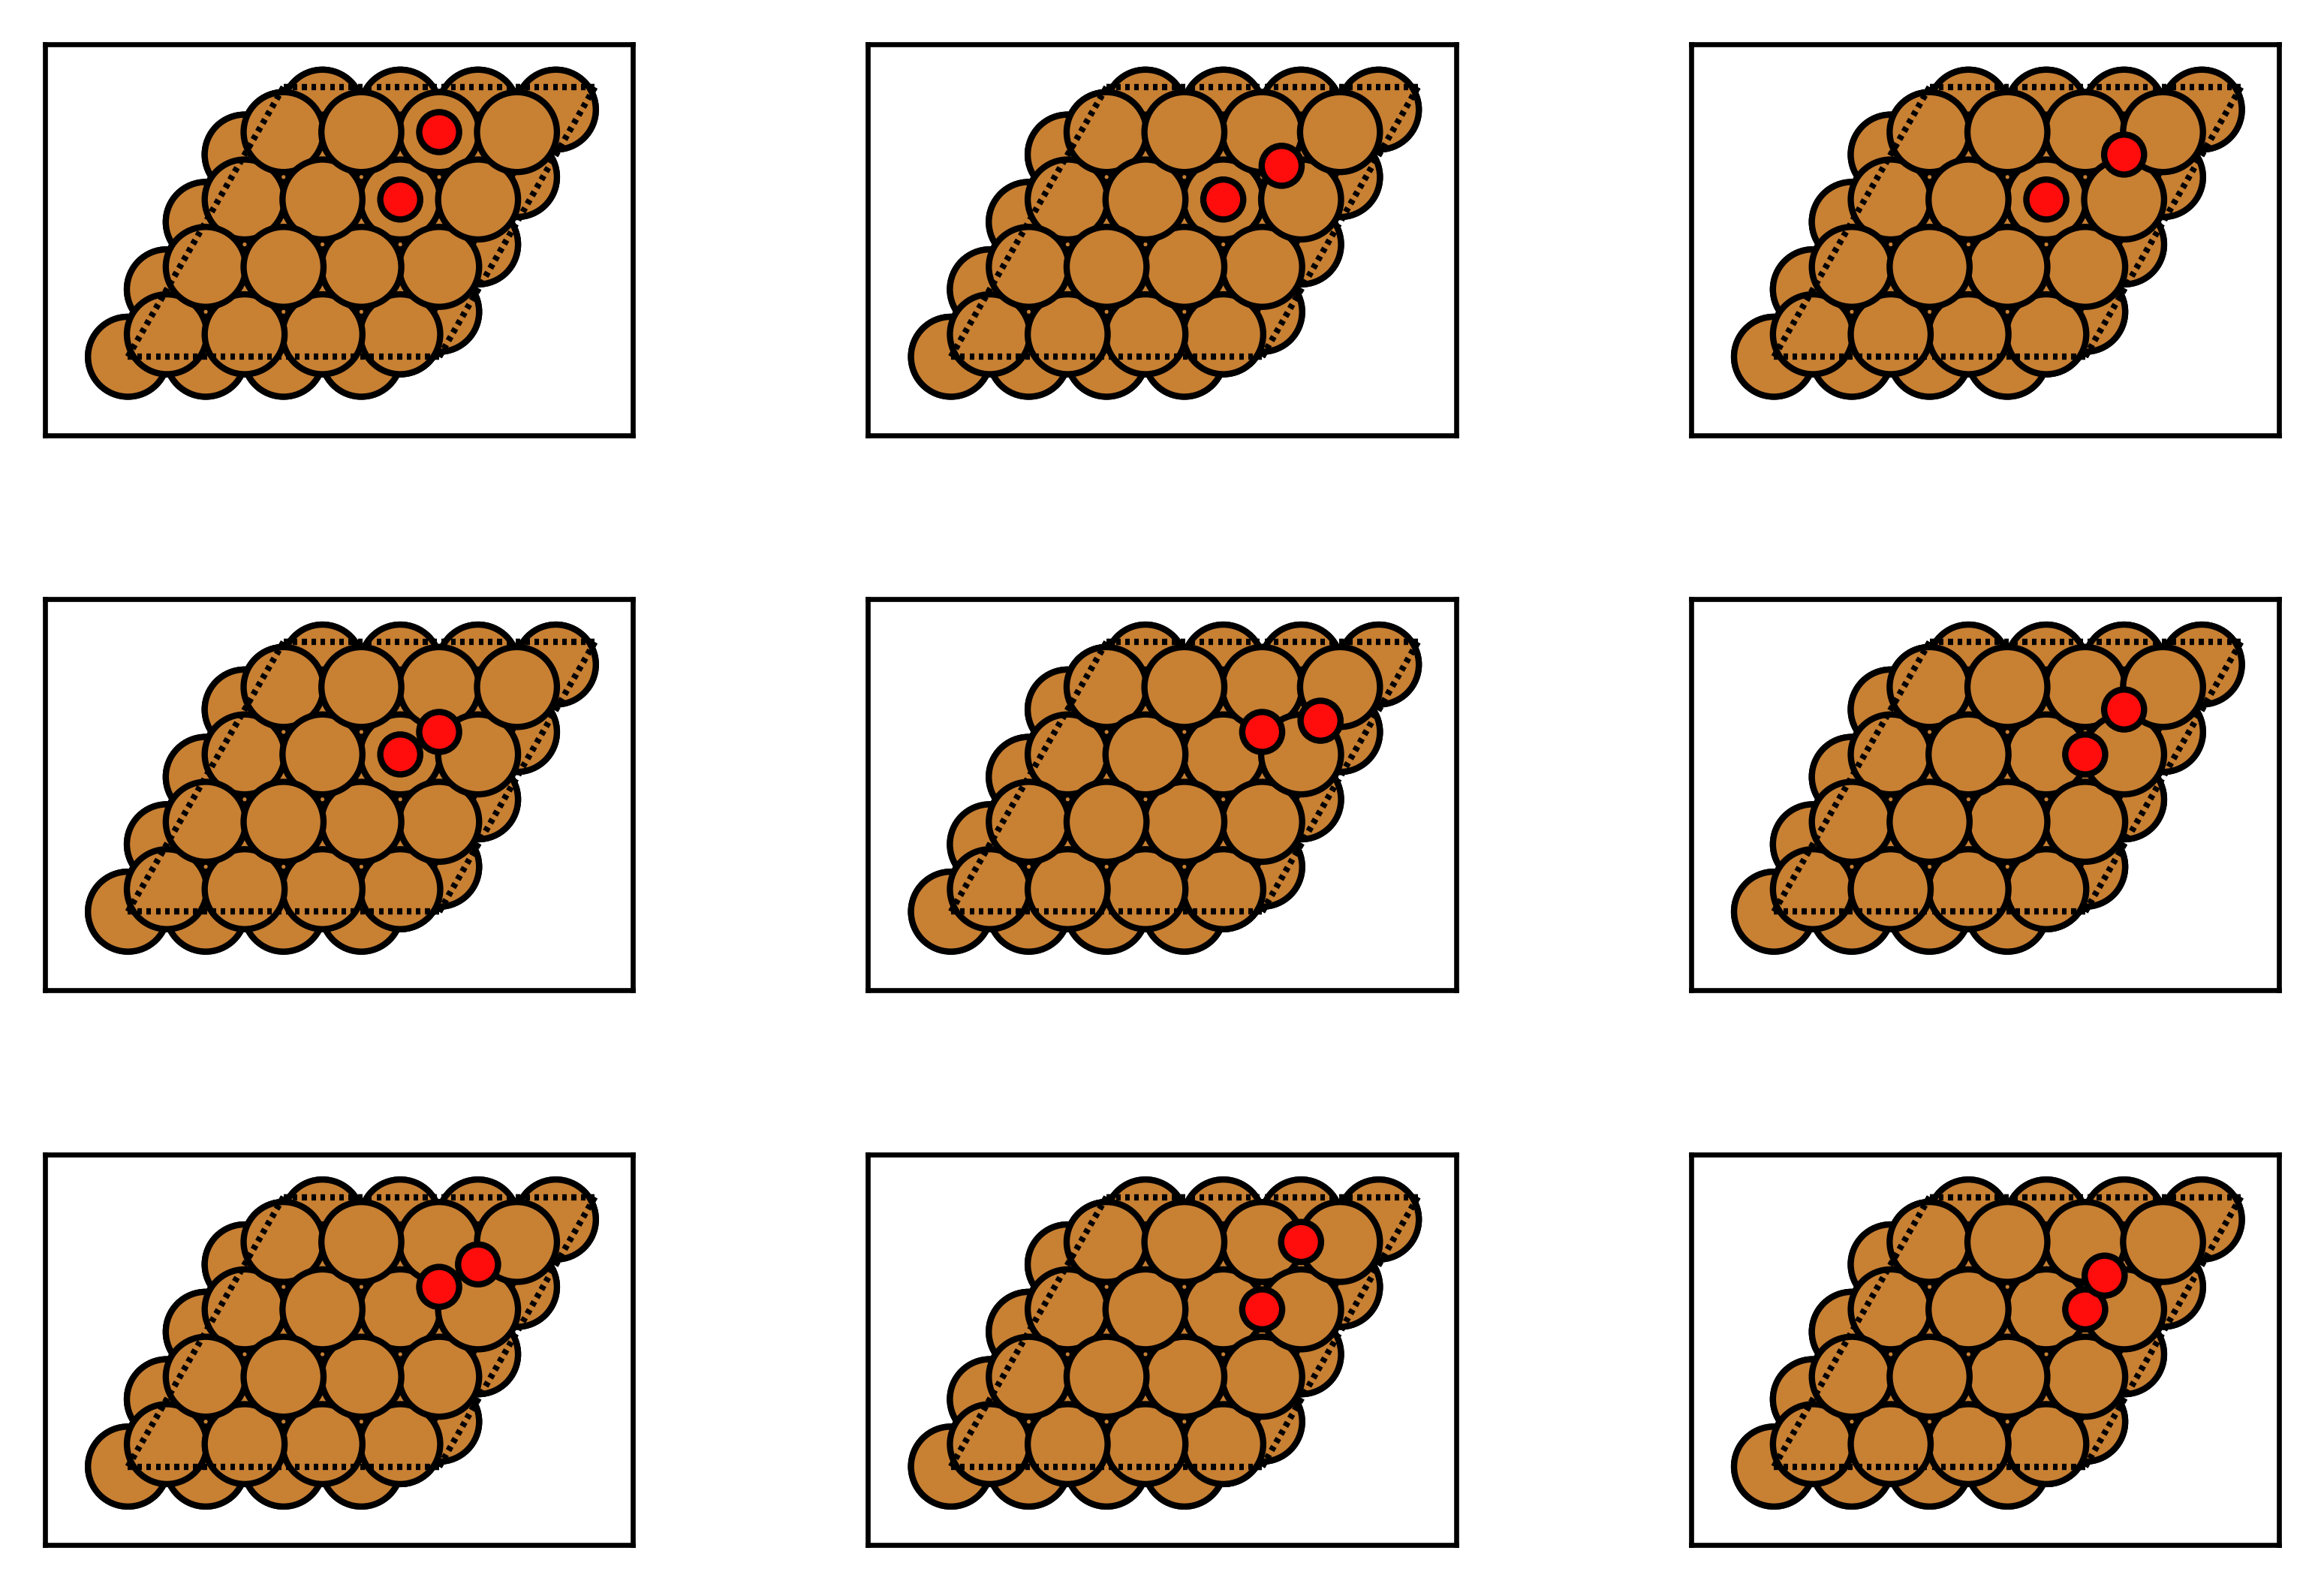

In [ ]:
out_poscar(molecule_model, nostrain_molecule_folder)
plot_top(molecule_model, column=3)

wait calculation complete

In [ ]:
molecule_model_relax_l, molecule_model_relax_d = read_car(
    nostrain_molecule_copy, car="CONTCAR"
)  # car='CONTCAR'

1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008'])


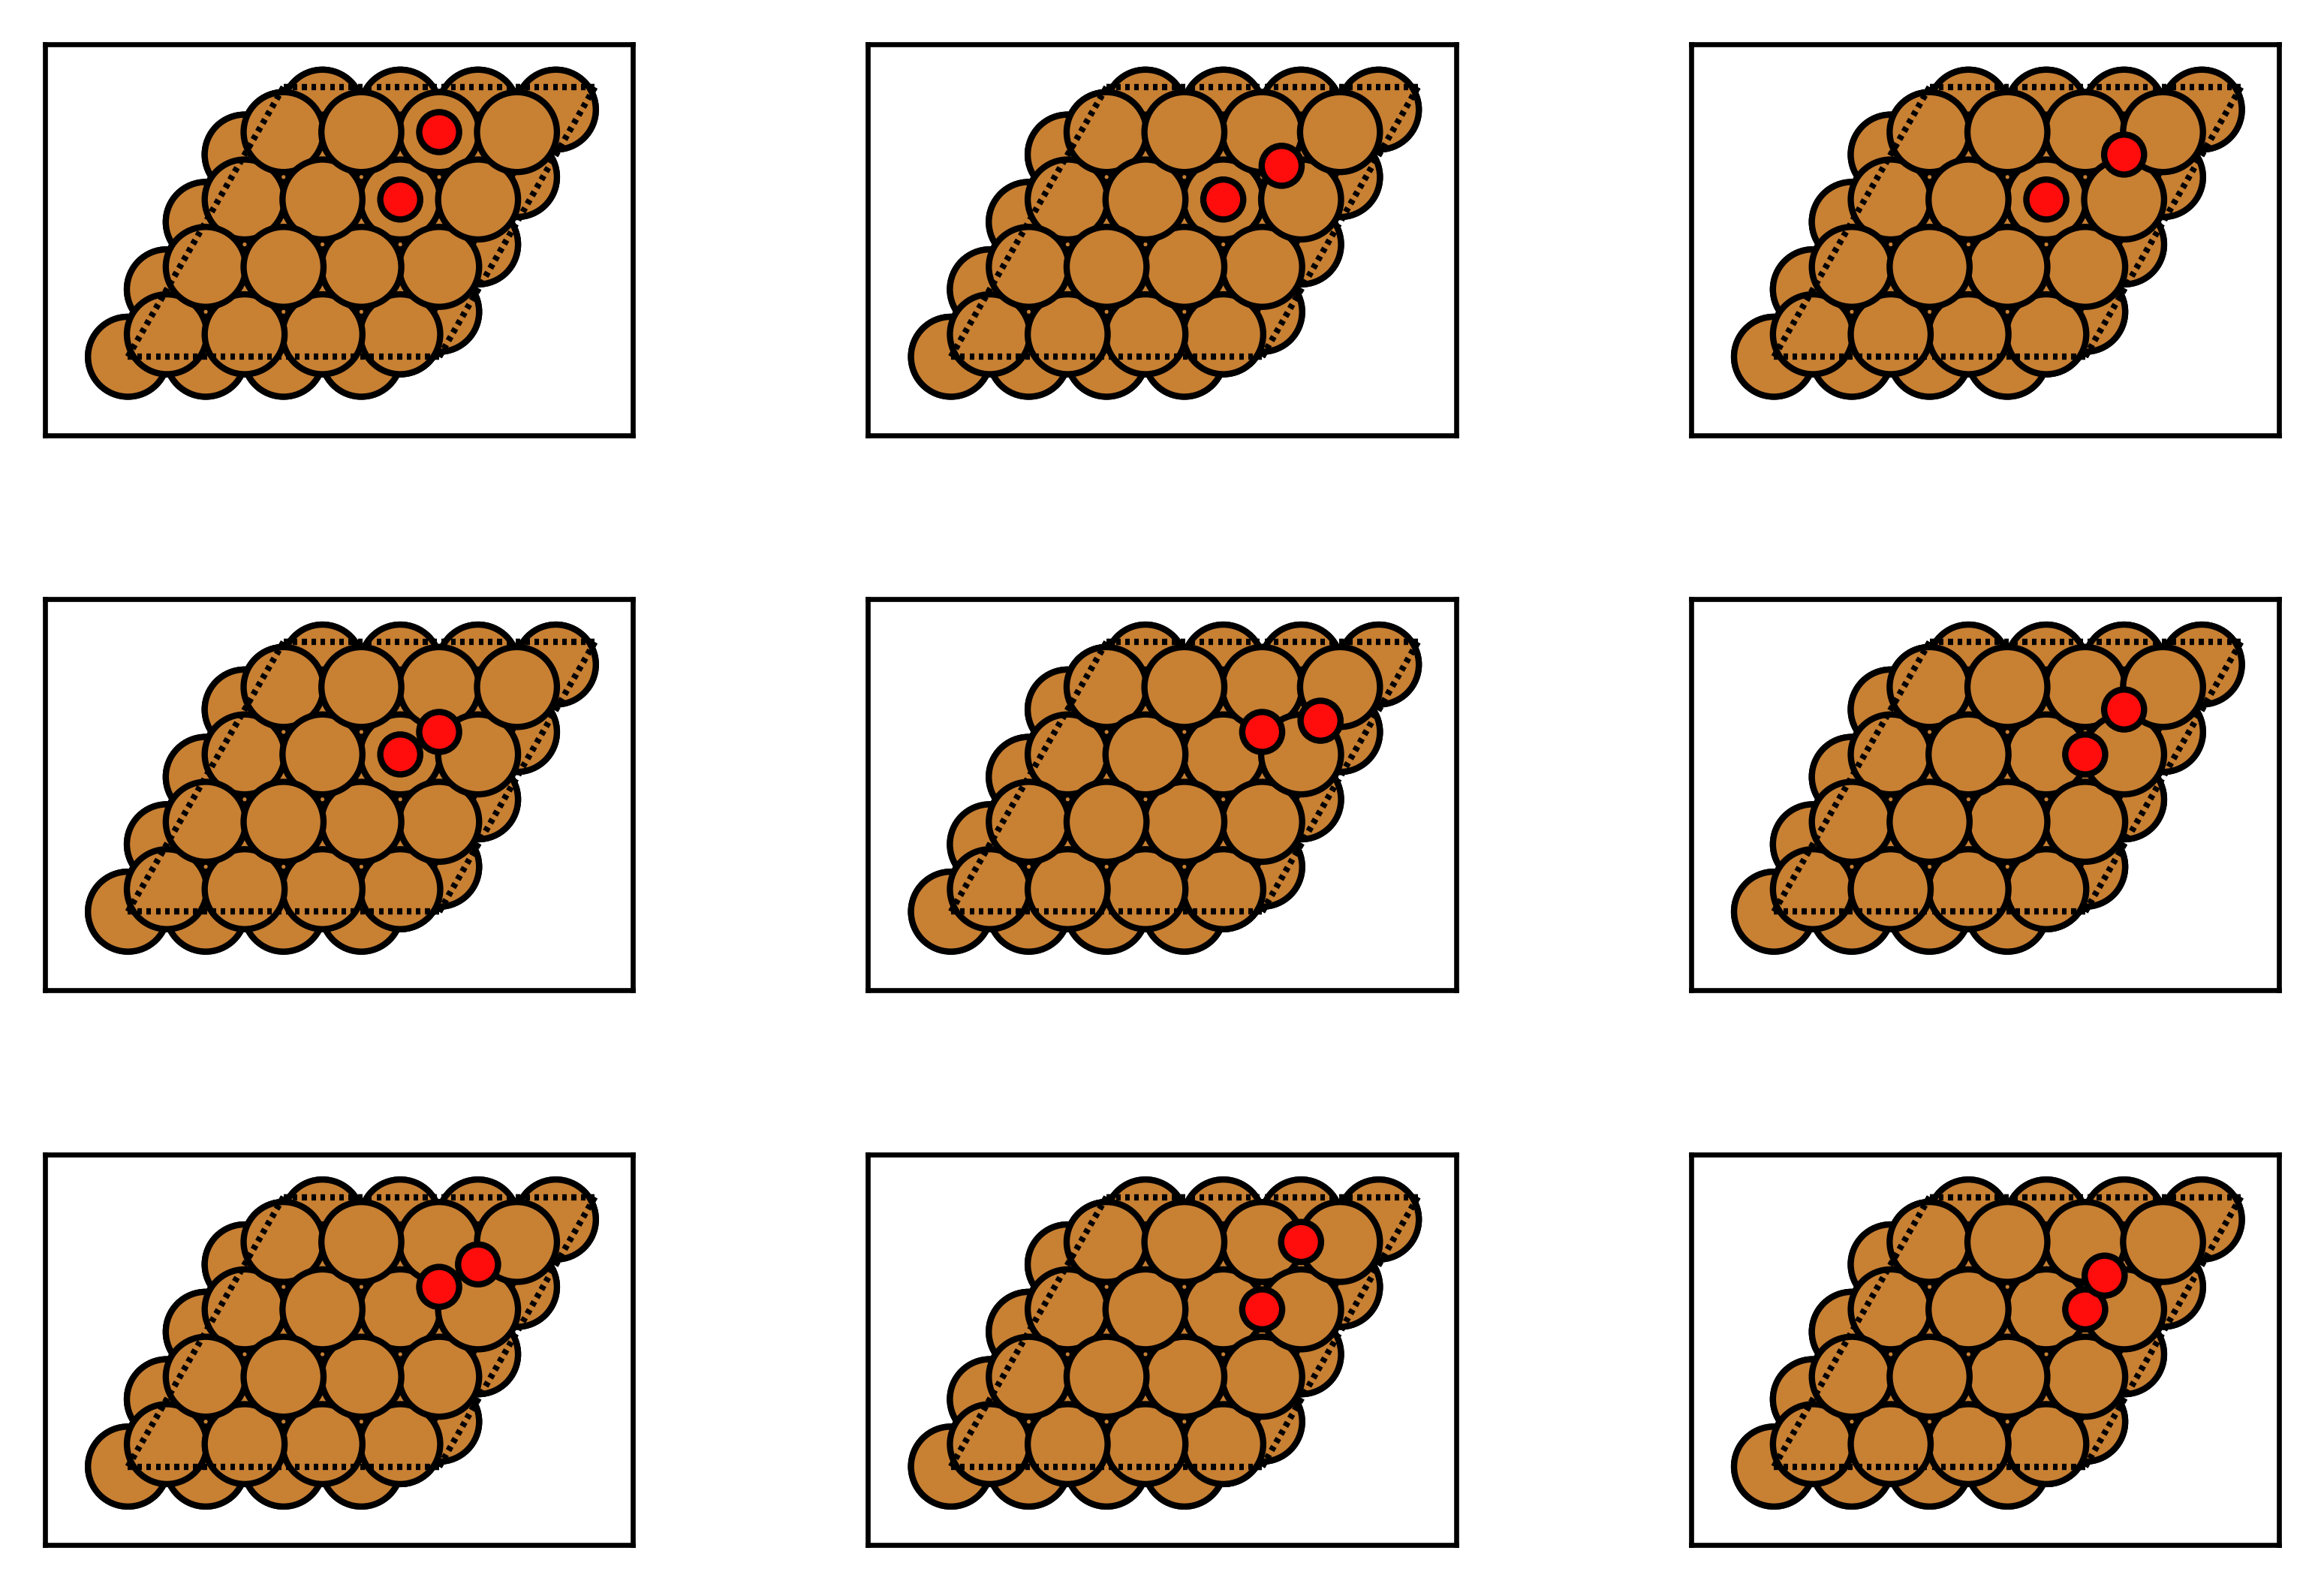

In [ ]:
plot_top(molecule_model_relax_l, column=3)

In [ ]:
molecule_energy_relax_l, molecule_energy_relax_d = read_car(
    nostrain_molecule_copy, car="OSZICAR"
)

E0 value: -1 F   -.41152881E+03
E0 value: -1 F   -.41238936E+03
E0 value: -1 F   -.41347738E+03
E0 value: -1 F   -.41263940E+03
E0 value: -1 F   -.41329765E+03
E0 value: -1 F   -.41322994E+03
E0 value: -1 F   -.41269243E+03
E0 value: -1 F   -.41402914E+03
E0 value: -1 F   -.41252577E+03
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008'])


## 4.3 Rotate

Asymmetric strain can cause configuration asymmetry

In [ ]:
molecule_d = {}
for i in range(len(molecule_name)):
    molecule_text = f"{molecule_name[i][0]}_{molecule_name[i][1]}"
    molecule_d[molecule_text] = molecule_model_relax_l[i]

mol_rotate_d = {}
axis = mel_d["hol_012"]
axis = axis[:2]
for key, r in itertools.product(molecule_d, range(3)):
    ra = 120 * (r)  # rotate angle
    # print(molecule_dic[key])
    adslab0 = molecule_d[key].copy()
    xypos = adslab0.positions[-2:, :2]
    xypos = rotate_point(xypos, axis, angle=ra)
    adslab0.positions[-2:, :2] = xypos
    mol_rotate_d[f"{key}_{str(ra)}"] = adslab0
len(mol_rotate_d)
mol_rotate_l = list(mol_rotate_d.values())

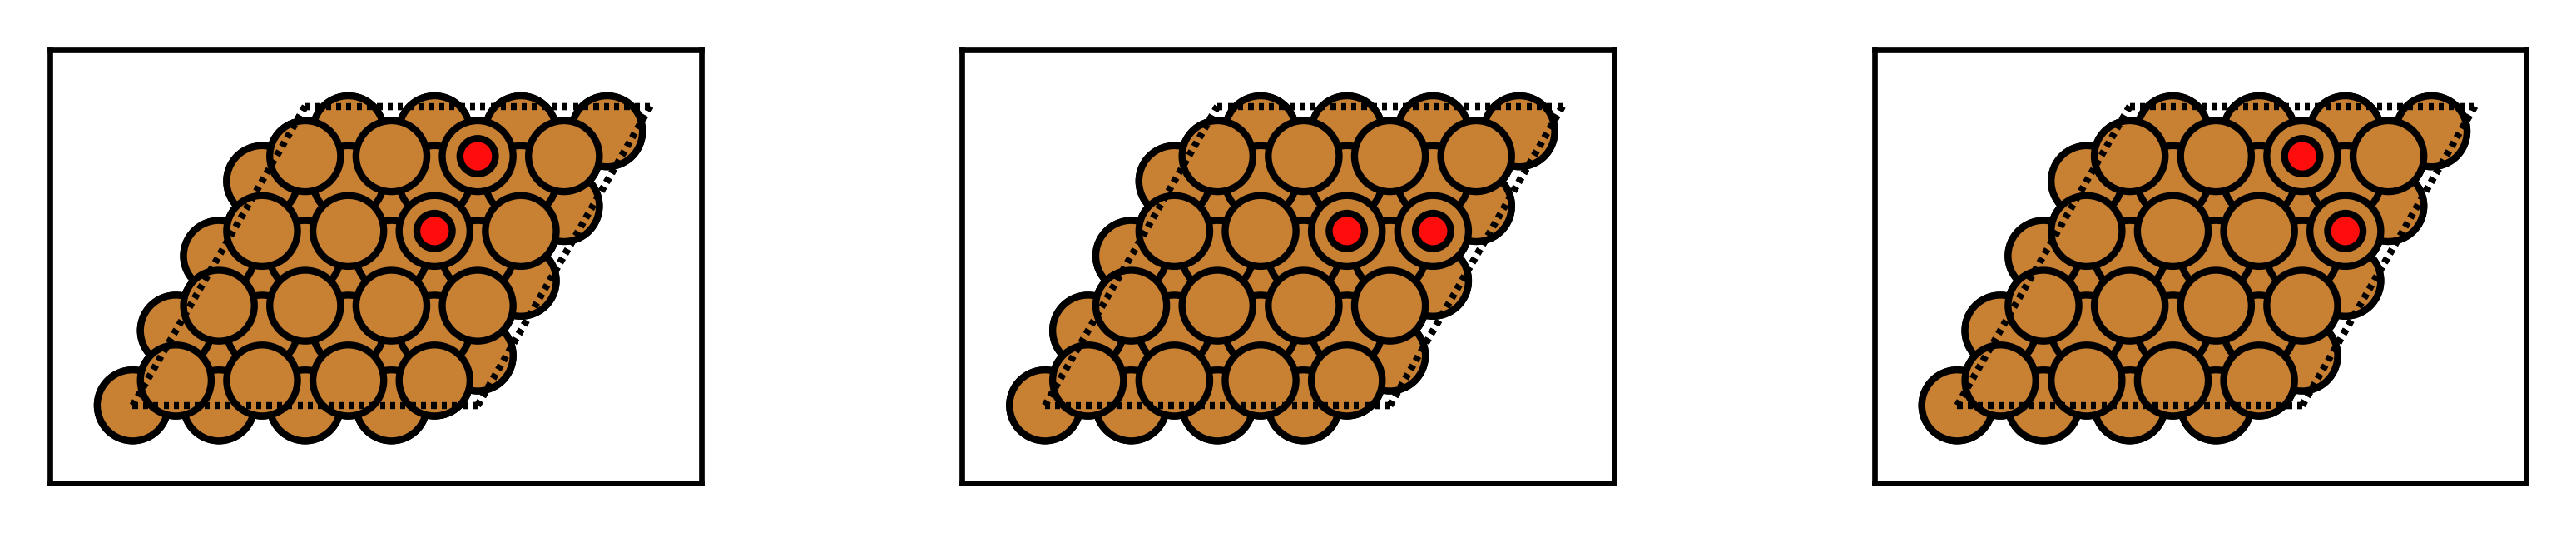

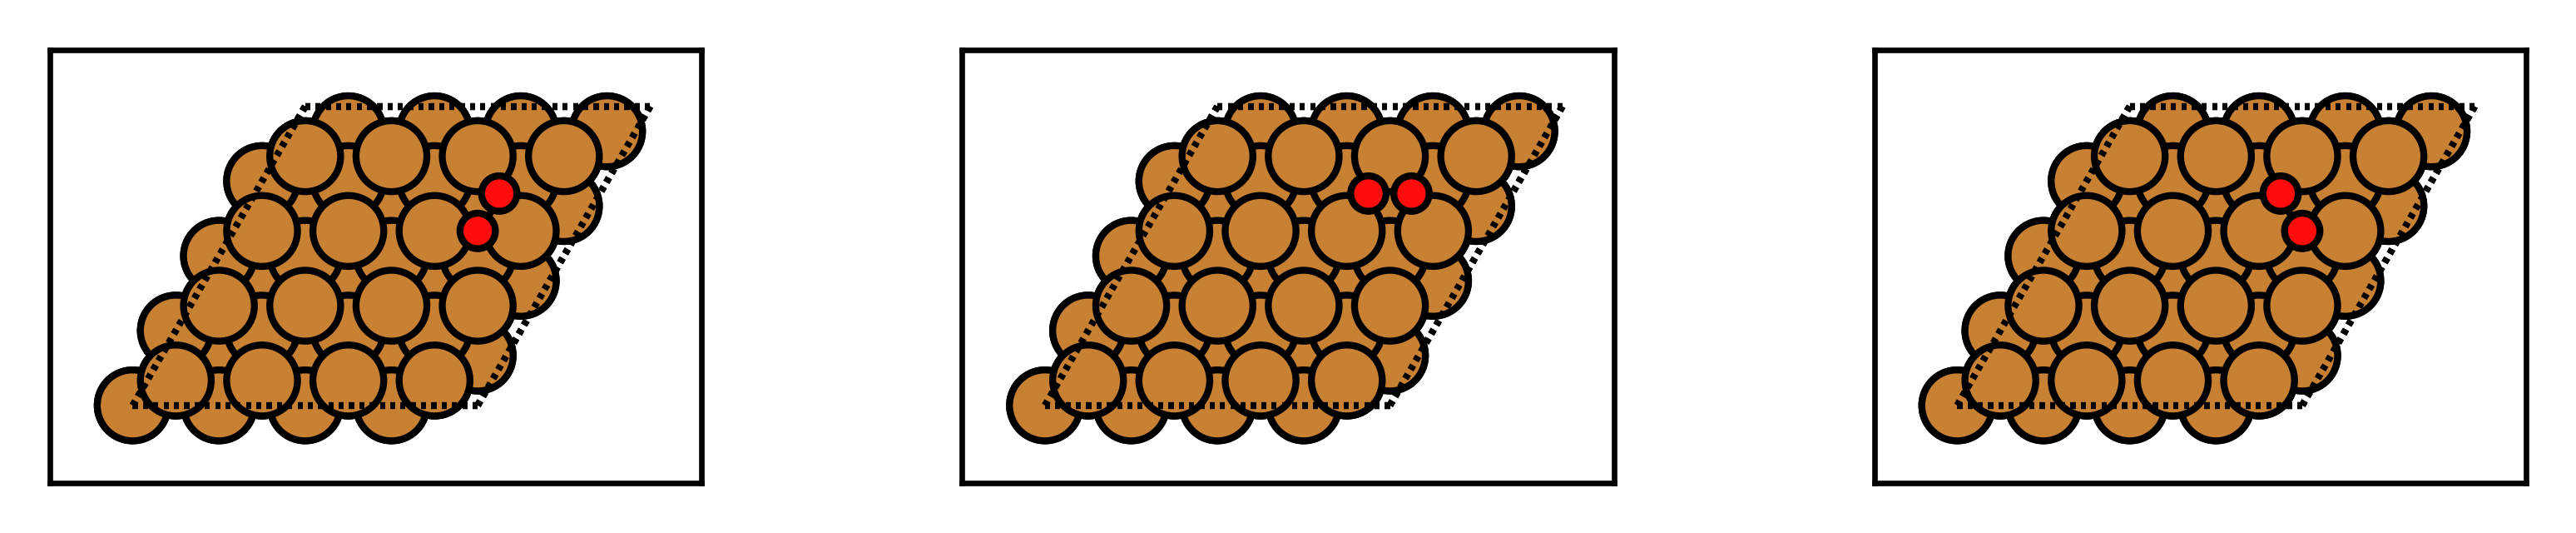

In [ ]:
plot_top(mol_rotate_l[:3], column=3, radii=0.8)
plot_top(mol_rotate_l[-3:], column=3, radii=0.8)
# out_poscar(mol_rotate_dic, path="./vasp_cala/nostrain_molecule3")

# 5. Set strain
There should be four processes: 

① applying strain to the bulk, executing optimization; 

② cutting out the slab, executing optimization; 

③ adsorbing molecules, executing optimization

Firstly, there should be the results of the above process with a no strain slab as a reference

## 5.1 Strain free configuration reference

需要构建吸附的（分子）两个原子和基底表面原子的对应关系。这个关系在 应变映射吸附分子初步推断起作用。

无应变吸附构型 和 有应变slab构型 推断 有应变吸附构型
可以认为与通道内的原子相关

In [ ]:
sort_nei_d = {}
for index, (key, adsalbi) in enumerate(mol_rotate_d.items()):
    # adsalbi.set_constriant()
    rot = int(int(key.split("_")[-1]) / 120)  # 共3个角度
    top1d = top3d[rot]
    adsi = adsalbi.get_positions()[-2:]
    fors = adsalbi[top3d[rot]].get_positions()
    rel = find_nearest_coordinate(adsi, fors)
    nei2 = []
    for j in rel:
        nei = [top1d[k] for k in j]
        nei2.append(nei)
    sort_nei_d[key] = nei2

sort_nei_l = list(sort_nei_d.values())  # 存储的是离吸附原子最近的基底原子
sort_nei_l

[[[76], [83]],
 [[104], [76]],
 [[83], [104]],
 [[76], [83, 104]],
 [[104], [76, 83]],
 [[83], [76, 104]],
 [[76], [83, 104, 111]],
 [[104], [76, 83, 55]],
 [[83], [76, 104, 97]],
 [[76], [76, 83, 104]],
 [[104], [76, 83, 104]],
 [[83], [76, 83, 104]],
 [[76, 83, 104], [104, 111]],
 [[76, 83, 104], [83, 55]],
 [[76, 83, 104], [76, 97]],
 [[83, 104, 111], [76, 104]],
 [[76, 83, 55], [83, 104]],
 [[76, 104, 97], [76, 83]],
 [[76, 83, 104], [83, 104, 111]],
 [[76, 83, 104], [76, 83, 55]],
 [[76, 83, 104], [76, 104, 97]],
 [[76, 104], [83, 111]],
 [[83, 104], [76, 55]],
 [[76, 83], [104, 97]],
 [[76, 104], [83, 104]],
 [[83, 104], [76, 83]],
 [[76, 83], [76, 104]]]

2


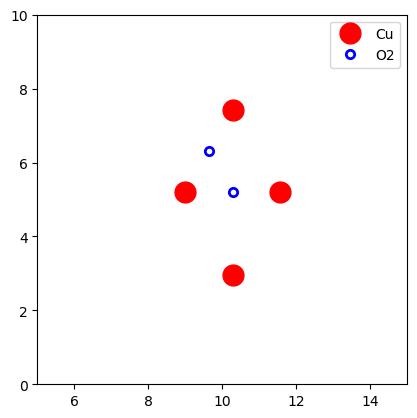

In [ ]:
i = 26  # 校验通道和吸附原子的位置关系 i < 27
keys = list(mol_rotate_d.keys())
key = keys[i]
adsalbi = mol_rotate_d[key]
# adsalbi.set_constriant()
rot = int(int(key.split("_")[-1]) / 120)
print(rot)

top1d = top3d[rot]
adsi = adsalbi.get_positions()[-2:]
fors = adsalbi[top3d[rot]].get_positions()
rel = find_nearest_coordinate(adsi, fors)
plot_points(fors[:, :2], adsi[:, :2])
nei2 = []
for j in rel:
    nei = [top1d[k] for k in j]
    nei2.append(nei)

In [ ]:
strain_adslab_l, strain_adslab_d = get_strain_adslab(mol_rotate_d, strain_allpy_slabs_d2, sort_nei_l)
# mol_rotate_d 中是包含了旋转的分子吸附构型

top_0_top_1_0
top_0_top_1_120
top_0_top_1_240
top_0_bri_12_0
top_0_bri_12_120
top_0_bri_12_240
top_0_hol_123_0
top_0_hol_123_120
top_0_hol_123_240
top_0_hol_012_0
top_0_hol_012_120
top_0_hol_012_240
hol_012_bri_23_0
hol_012_bri_23_120
hol_012_bri_23_240
hol_123_bri_02_0
hol_123_bri_02_120
hol_123_bri_02_240
hol_012_hol_123_0
hol_012_hol_123_120
hol_012_hol_123_240
bri_02_bri_13_0
bri_02_bri_13_120
bri_02_bri_13_240
bri_02_bri_12_0
bri_02_bri_12_120
bri_02_bri_12_240


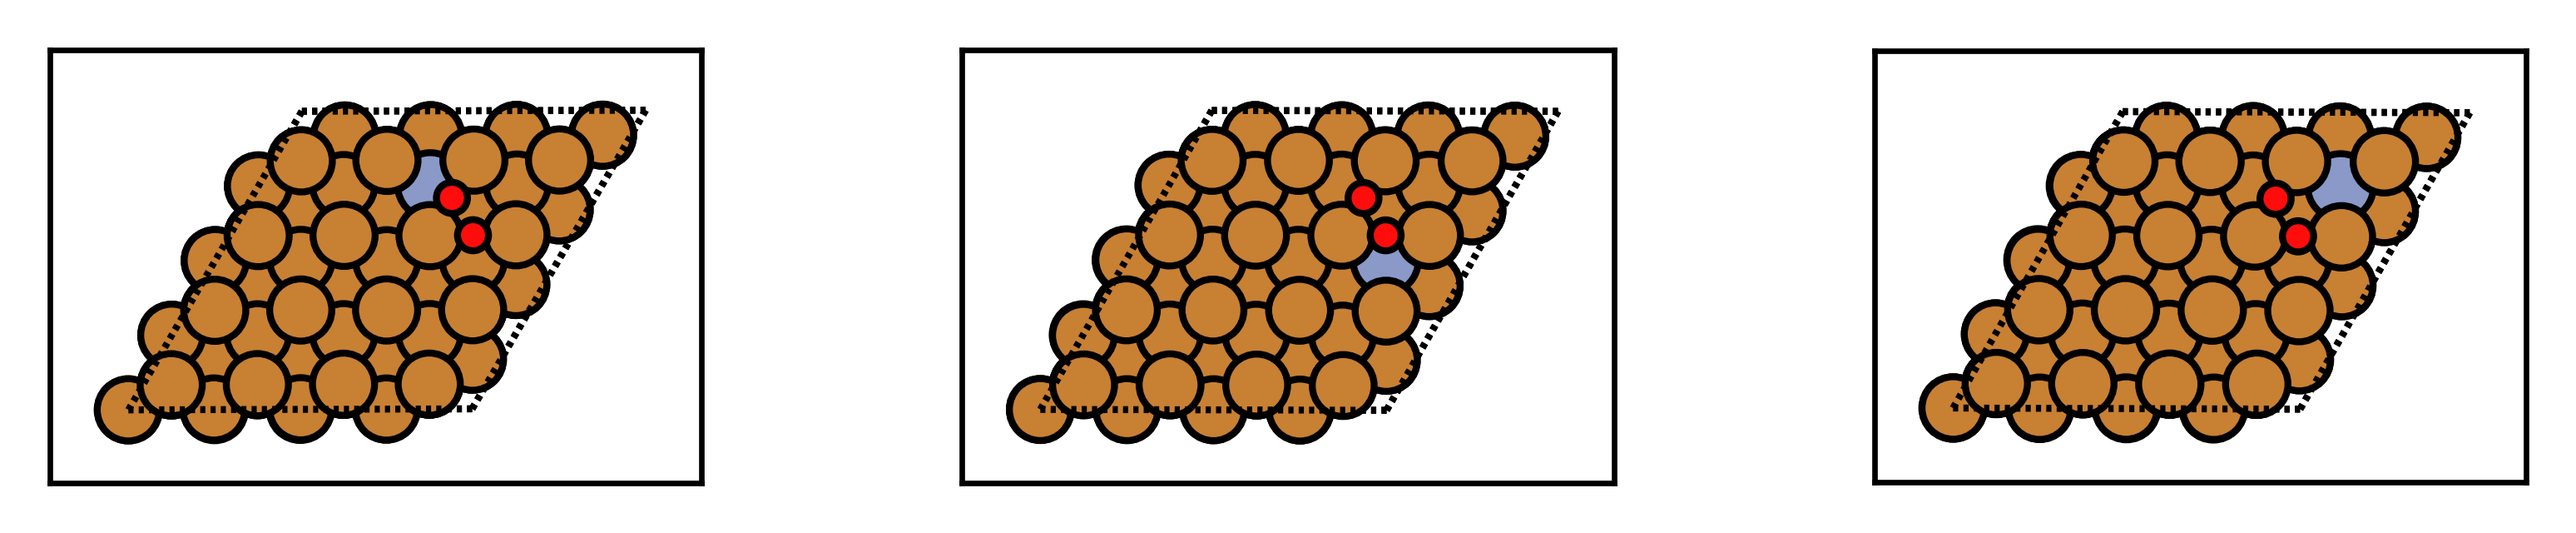

In [ ]:
plot_top(strain_adslab_l[-1][:3], radii=0.7)

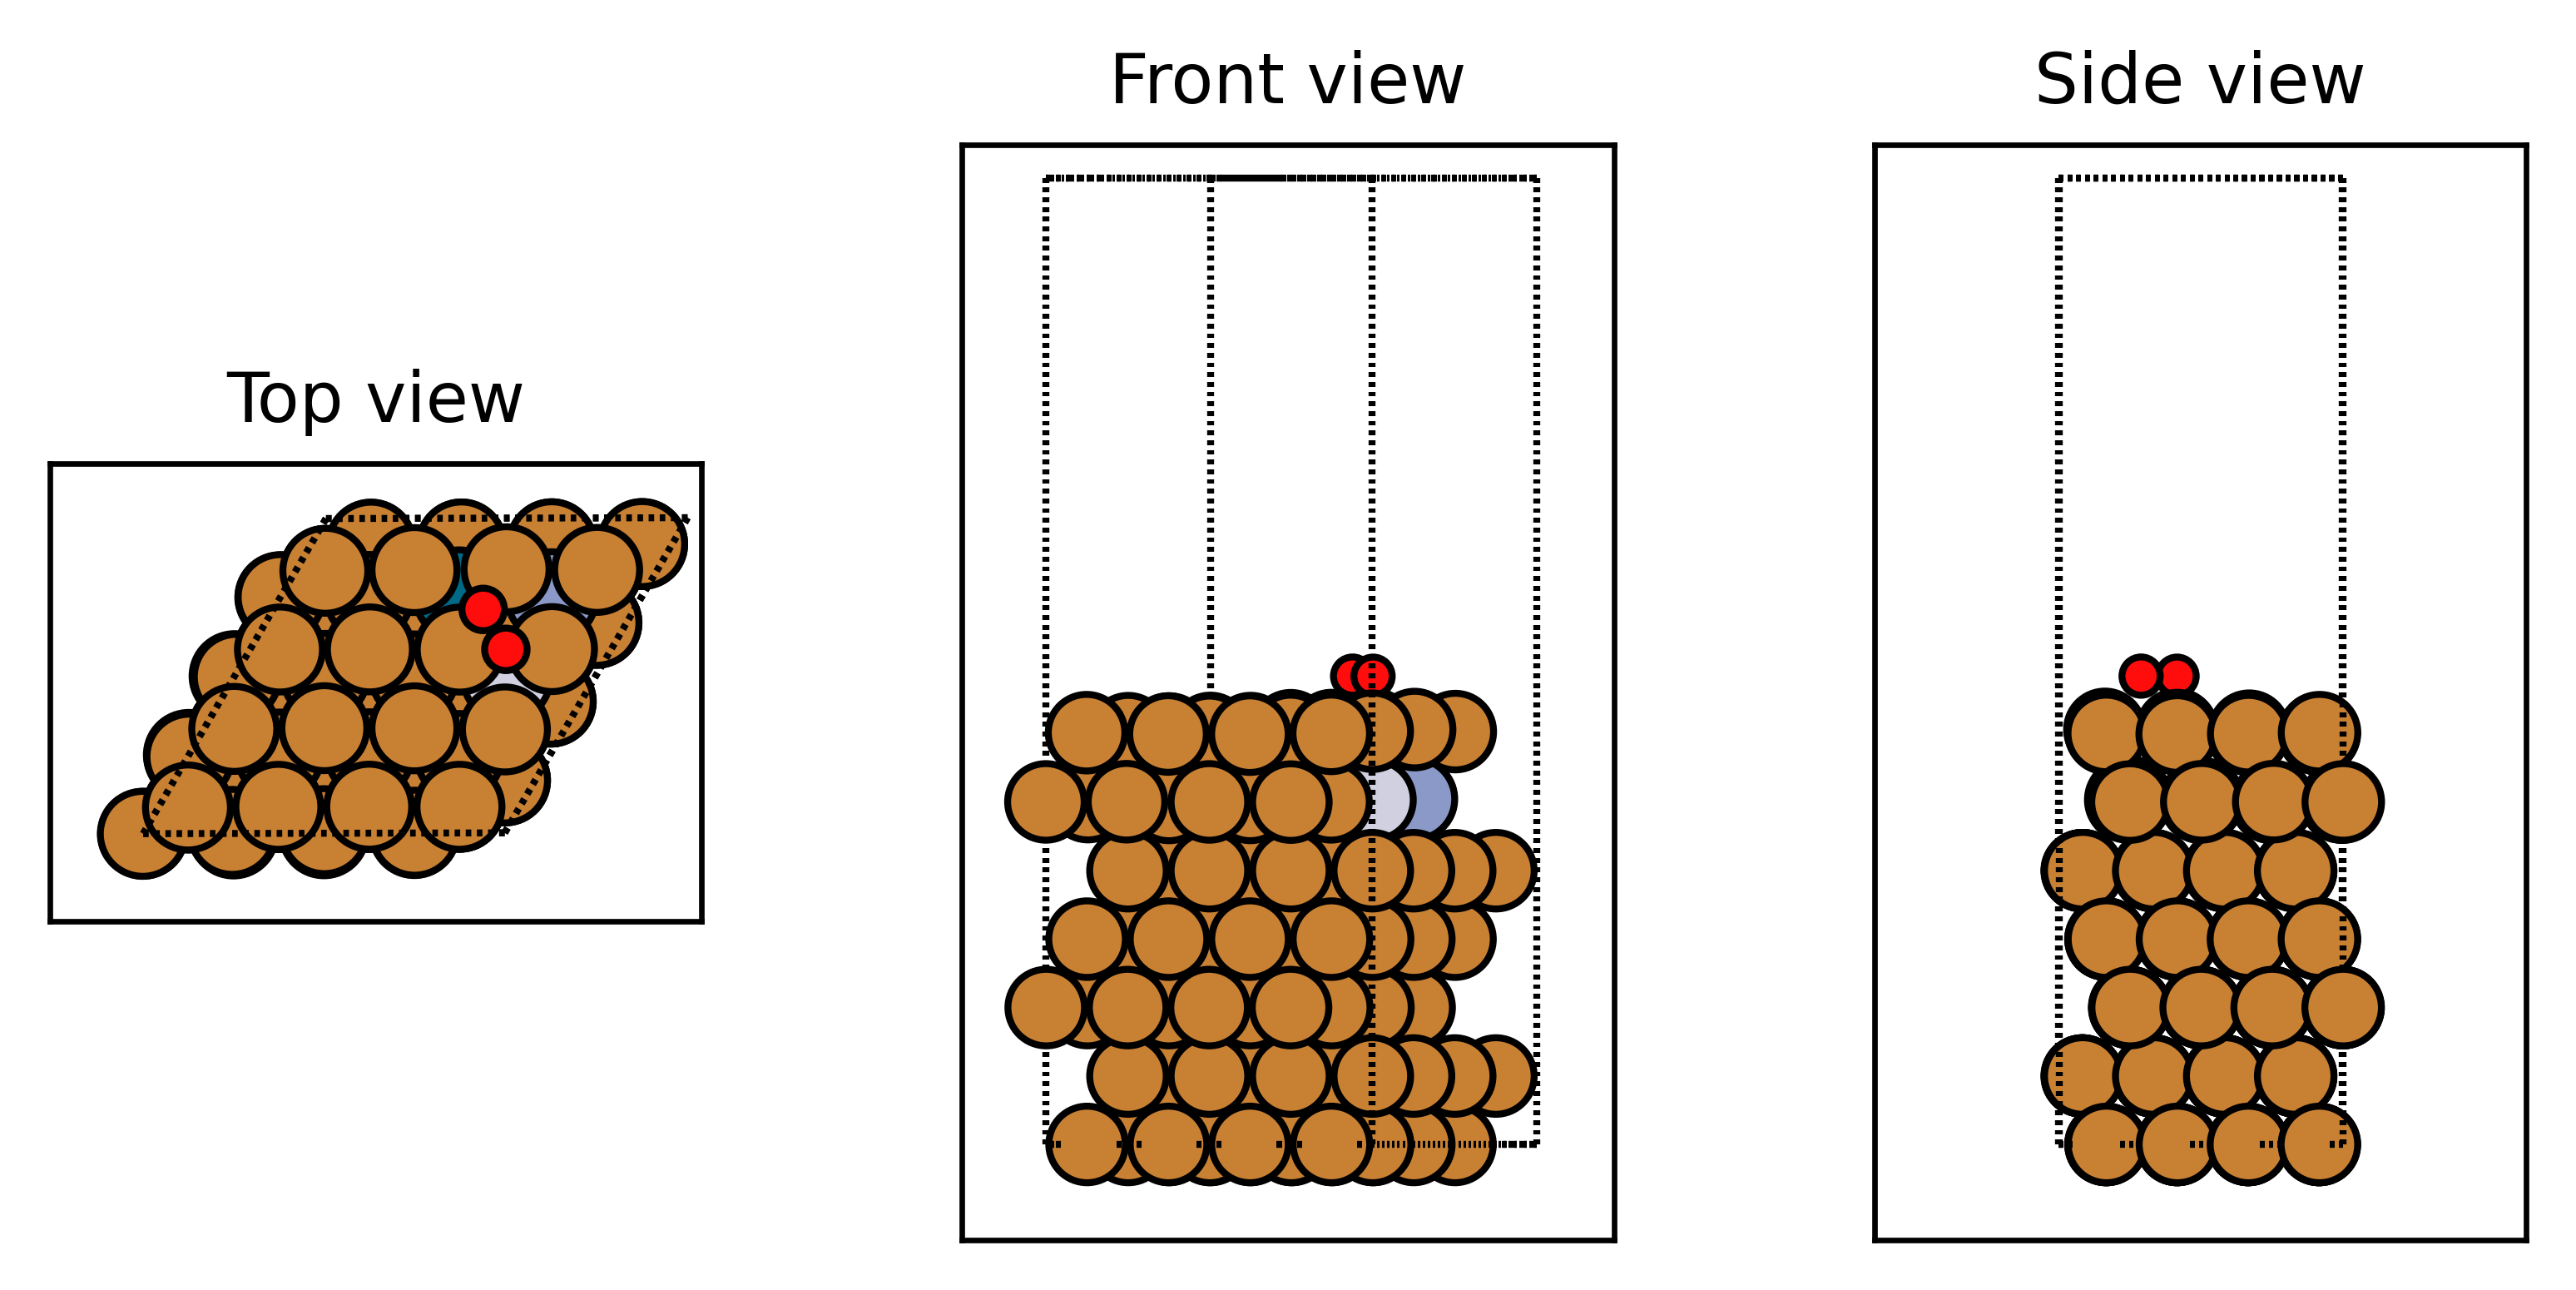

In [ ]:
plot_model(strain_adslab_l[-1][-1])

In [ ]:
out_car_list(strain_adslab_l, strain_adslab_folder)  # 最终的施加了应变的吸附结构

# 6. Initial Structure to Relaxed Energy/Structure (IS2RE/IS2RS) LMDBs

IS2RE/IS2RS LMDBs utilize the SinglePointLmdb dataset. This dataset expects the data to be contained in a SINGLE LMDB file. In addition to the attributes defined by AtomsToGraph, the following attributes must be added for the IS2RE/IS2RS tasks:

- pos_relaxed: Relaxed adslab positions
- sid: Unique system identifier, arbitrary
- y_init: Initial adslab energy, formerly Data.y
- y_relaxed: Relaxed adslab energy
- tags (optional): 0 - subsurface, 1 - surface, 2 - adsorbate


As a demo, we will use the above generated data to create an IS2R* LMDB file.

In [ ]:
# 存储的是有应变的基底，乘以16倍就是等价的基底
# strain_slab_int = read_cars(refer_slab_copy, car="POSCAR")
# strain_slab_opt = read_cars(refer_slab_copy, car="CONTCAR")
# strain_slab_eng = read_cars(refer_slab_copy, car="OSZICAR")

In [ ]:
# 存储的是有应变的基底，不需要乘以16倍
strain_slab_int = read_cars(alloy_slab_copy, car="POSCAR")
strain_slab_opt = read_cars(alloy_slab_copy, car="CONTCAR")
strain_slab_eng = read_cars(alloy_slab_copy, car="OSZICAR")

1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '

In [ ]:
# 存储的是有应变的吸附构型
# strain_adslab_folder = "/media/zwbai/DATA/dft/shear/strain_adslab_copy/"
strain_adslab_int = read_cars(strain_adslab_copy, car="POSCAR")
strain_adslab_opt = read_cars(strain_adslab_copy, car="CONTCAR")
strain_adslab_eng = read_cars(strain_adslab_copy, car="OSZICAR")
strain_adslab_ine = read_cars(strain_adslab_copy, car=["OSZICAR", 0])
len(strain_adslab_int[0]), len(strain_adslab_int[0][0])

1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '

(27, 21)

In [ ]:
ml_bulk_l, ml_bulk_d = get_bulk_set(bulk, strain_matrix)  # bulk上施加应变
ml_slab_l0 = bulk2slab(ml_bulk_l)  # 生成表面
ml_slab_l, ml_slab_d = slab2slabs(ml_slab_l0)  # 拓展
ml_s_a_slabs_l, ml_s_a_slabs_d = get_strain_alloy_slabs(alloy_slab_l, ml_slab_l)

In [ ]:
ml_s_a_adslabs_l, ml_s_a_adslabs_d= get_strain_adslab(mol_rotate_d, ml_s_a_slabs_d, sort_nei_l)
len(ml_s_a_adslabs_l), len(ml_s_a_adslabs_l[0])

top_0_top_1_0
top_0_top_1_120
top_0_top_1_240
top_0_bri_12_0
top_0_bri_12_120
top_0_bri_12_240
top_0_hol_123_0
top_0_hol_123_120
top_0_hol_123_240
top_0_hol_012_0
top_0_hol_012_120
top_0_hol_012_240
hol_012_bri_23_0
hol_012_bri_23_120
hol_012_bri_23_240
hol_123_bri_02_0
hol_123_bri_02_120
hol_123_bri_02_240
hol_012_hol_123_0
hol_012_hol_123_120
hol_012_hol_123_240
bri_02_bri_13_0
bri_02_bri_13_120
bri_02_bri_13_240
bri_02_bri_12_0
bri_02_bri_12_120
bri_02_bri_12_240


(27, 21)

#### Initialize AtomsToGraph feature extractor

In [ ]:
E0_O2 = -0.98504822e01  # 02分子的能量
E0_O2

-9.8504822

In [ ]:
istore = False

In [ ]:
if istore:
    ml_GNN_data_d = get_GNN_data(
        ml_s_a_adslabs_d,
        int_eng=None,
        ads_opt=strain_adslab_opt[1],
        opt_eng=strain_adslab_eng[1],
        slab_eng=strain_slab_eng[1],
        E0_O2=E0_O2,
    )
    with open(ml_GNN_data_dict, "wb") as file:  # 字典形式保存，该格式方便合并
        pickle.dump(ml_GNN_data_d, file)
else:
    with open(ml_GNN_data_dict, "rb") as file:
        ml_GNN_data_d = pickle.load(file)

#### Initialize LMDB file

In [ ]:
if istore:
    del_file(lmdb_file_ml)
    del_file(f"{lmdb_file_ml}-lock")

    db_ml = lmdb.open(
        lmdb_file_ml,
        map_size=1024 * 1024 * 1024 * 2,
        subdir=False,
        meminit=False,
        map_async=True,
    )
# 本次执行获得的数据

In [ ]:
if istore:
    idx = 0  # 数据库方式保存，可以执行机器学习
    for key, value in ml_GNN_data_d.items():
        for value0 in value:
            value0.sid = idx
            # Write to LMDB
            txn = db_ml.begin(write=True)
            txn.put(
                f"{idx}".encode("ascii"),
                pickle.dumps(value0, protocol=-1),
            )
            txn.commit()
            db_ml.sync()
            print(idx)
            idx += 1
    db_ml.close()

In [ ]:
print("lmdb all file path:", lmdb_file_ml)
all_dataset = LmdbDataset({"src": lmdb_file_ml})

all_energies = [data.y_relaxed for data in all_dataset]
mean = np.mean(all_energies)
stdev = np.std(all_energies)
mean, stdev, len(all_energies)

lmdb all file path: /media/zwbai/DATA/dft/alloy_copy/output/CuO2_strain_ml.lmdb


(-0.9238154543209863, 0.7398845306211789, 567)

In [ ]:
max(all_energies)

0.5811322000000256

# 7. build DOS dataset 

In [ ]:
pos = adslab.get_positions()
cell = adslab.get_cell()
anum = np.array([int(n) for n in adslab.get_atomic_numbers()])
tri = [
    point_position(cell[0], cell[1], posi[:2])
    and posi[2] > min(sorted(pos[:, 2], reverse=True)[:18])
    for posi in pos
]  #  tri 是一个布尔值列表
tri = [i for i in range(len(adslab)) if tri[i]]  #  tri 是一个序号列表


def get_dos(dos_folder):  # 包装
    _, dos = get_dos_atom_orbitals(dos_folder, tri)  # 要获得tri中标记的原子的dos
    return dos

In [ ]:
dos_l, dos_d = read_cars(dos_cal, car=get_dos)  # need 7 min

1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '

In [ ]:
atomdos_l, atomdos_d = read_cars(dos_cal, car="POSCAR")

1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '

In [ ]:
lenth = len(dos_l[0])
shape_dos_l0 = dos_l[0][0].shape
dos_data = np.zeros(
    (len(dos_l) * len(dos_l[0]), shape_dos_l0[0], shape_dos_l0[1], shape_dos_l0[2])
)

for i in range(len(dos_l)):
    for j in range(len(dos_l[0])):
        k = i * lenth + j
        dos_data[k] = dos_l[i][j]
dos_data.shape

(567, 1600, 6, 9)

In [ ]:
targets = np.array(all_energies)
targets.shape

(567,)

In [ ]:
print(dos_data.shape)
with open(dos_data_file, mode="wb") as f:
    pickle.dump(dos_data, f)
    pickle.dump(targets, f)

(567, 1600, 6, 9)


In [ ]:
dos_e, _ = get_dos_atom_orbitals(dos_cal + "/1000/1000", tri)  # dos_e 是能量轴

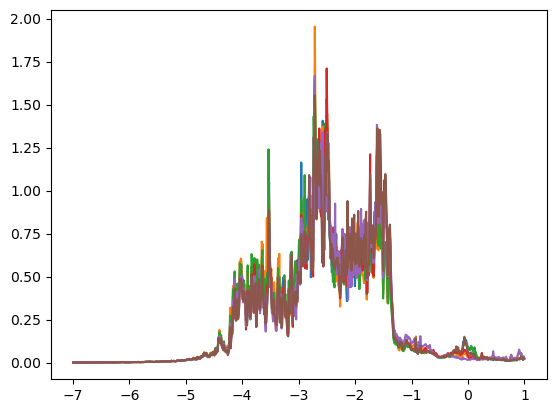

In [ ]:
for i in range(0, 6):
    plt.plot(dos_e[100:900], dos_data[0, 100:900, i, 8])
plt.show()

# 8. Creat Dos Set

## 8.1 Function

## 8.2 strain model and dos data

In [ ]:
with open(dos_data_file, mode="rb") as f:
    surface_dos_data = pickle.load(f)
    targets = pickle.load(f)

In [ ]:
min(targets), max(targets)

(-2.5467578000000106, 0.5811322000000256)

In [ ]:
surface_dos_data.shape, targets.shape

((567, 1600, 6, 9), (567,))

In [ ]:
dosdata = surface_dos_data[:, 100:900, :, 4:]
dos_e = dos_e[100:900]
# dosdata[:, :, 0] = surface_dos_data[:, 100:900, 0]
dosdata.shape

(567, 800, 6, 5)

0.3691021999999986 0.5632622000000094


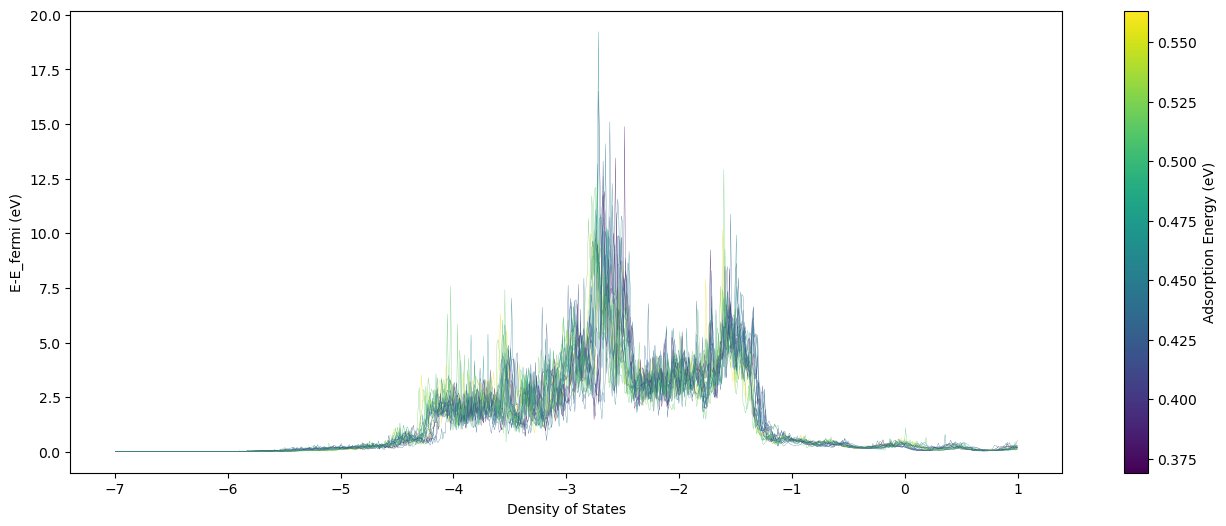

In [ ]:
# 创建彩虹图的 colormap
cmap = plt.get_cmap("rainbow")

z = all_energies[:22]
# 创建彩虹图的 colormap
cmap = plt.get_cmap("viridis")

# 设置合适的数值范围
vmin = np.min(z)
vmax = np.max(z)
print(vmin, vmax)
fig, ax = plt.subplots(figsize=(16, 6))

for i in range(22):
    # color = cmap(z[i])
    color = cmap((z[i] - vmin) / (vmax - vmin))
    # color = cmap(energies[i])  # 根据 z 的值获取对应的颜色
    ax.plot(dos_e, np.sum(dosdata[i, :, :, 4], axis=1), color=color, linewidth=0.2)

# 添加颜色条
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])  # 设置一个空数组，传递给 colorbar
cbar = plt.colorbar(sm, ax=ax)

# 添加标签
ax.set_xlabel("Density of States")
ax.set_ylabel("E-E_fermi (eV)")
cbar.set_label("Adsorption Energy (eV)")

plt.show()

# 8.3 Dataset

In [ ]:
row_index = [8, 29]
matrix_zeros = np.zeros([len(row_index), len(row_index)])
columns_index = row_index
table = pd.DataFrame(matrix_zeros, columns=columns_index, index=row_index)
table[:][:] = 2.0
table[29][29] = 2.8
print(table)

     8    29
8   2.0  2.0
29  2.0  2.8


In [ ]:
g = atom2graph(all_dataset[0], dosdata[0], threshold=table)
g

NameError: name 'sp_distance' is not defined

In [ ]:
g.x.shape

(8, 4000)

In [ ]:
channel = 5
d = dosdata[0][:, 1:].reshape((1, -1))
d0 = d.reshape(channel, -1).T
d0.shape

(4000, 5)

In [ ]:
graph_data = []
for i in range(len(all_dataset)):
    g = atom2graph(all_dataset[i], dosdata[i], threshold=table)
    graph_data.append(g)

In [ ]:
class MyGraphDataset(Dataset):
    """
    A dataset of density of states of mentals
    """

    def __init__(self, graph_list, **kwargs):
        self.graph_list = graph_list
        super().__init__(**kwargs)

    def download(self):
        if self.path is None:
            print("self.path is None")
        else:
            with open(self.path, "wb") as file:
                pickle.dump(self.graph_list, file)

    def read(self):
        # We must return a list of Graph objects
        output = []
        for i in range(len(self.graph_list)):
            output.append(self.graph_list[i])
        return output

    def __len__(self):
        return len(self.graph_list)

    def __getitem__(self, index):
        return self.graph_list[index]

In [ ]:
GraphDataset = MyGraphDataset(graph_data)
GraphDataset[0]

Graph(n_nodes=8, n_node_features=4000, n_edge_features=4, n_labels=1)

In [ ]:
GraphDataset.graphs

[Graph(n_nodes=8, n_node_features=4000, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=4000, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=4000, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=4000, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=4000, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=4000, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=4000, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=4000, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=4000, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=4000, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=4000, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=4000, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=4000, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=4000, n_edge_features=4, n_lab

In [ ]:
# 存储数据到文件
with open(dos_energy_data_file, "wb") as file:
    pickle.dump(GraphDataset, file)

In [ ]:
# 从文件中提取数据
with open(dos_energy_data_file, "rb") as file:
    loaded_data = pickle.load(file)

print(loaded_data)  # 输出：[1, 2, 3, 4, 5]
loaded_data[0]

MyGraphDataset(n_graphs=567)


Graph(n_nodes=8, n_node_features=4000, n_edge_features=4, n_labels=1)

In [ ]:
exist_folder(data_path, is_creat=True)
for file in pack_data_files:
    shutil.copy(file, data_path)  # copy file for further ML

folder '/media/zwbai/DATA/dft/alloy_copy/vasp_cal/' exists


In [ ]:
nostrain_slab_e = read_one_car(Cu_slab_copy, car="OSZICAR") * 4 * 4
nostrain_slab_e

E0 value: -1 F   -.25183315E+02


-402.93304

In [ ]:
nostrain_slabs_e = read_car(nostrain_molecule_copy, car="OSZICAR")

E0 value: -1 F   -.41152881E+03
E0 value: -1 F   -.41238936E+03
E0 value: -1 F   -.41347738E+03
E0 value: -1 F   -.41263940E+03
E0 value: -1 F   -.41329765E+03
E0 value: -1 F   -.41322994E+03
E0 value: -1 F   -.41269243E+03
E0 value: -1 F   -.41402914E+03
E0 value: -1 F   -.41252577E+03
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008'])


In [ ]:
np.array(nostrain_slabs_e[0]) - nostrain_slab_e - E0_O2
# 未加应变调制的基础吸附能

array([ 1.2547,  0.3942, -0.6939,  0.1441, -0.5141, -0.4464,  0.0911, -1.2456,  0.2578])

# 9. Combination 

In [ ]:
with open("/media/zwbai/DATA/dft/all/vasp_cal/GNN_data_dict.pkl", "rb") as file:
    GNN_data_d0 = pickle.load(file)

In [ ]:
with open("/media/zwbai/DATA/dft/all/vasp_cal/GNN_data_dict.pkl", "rb") as file:
    GNN_data_d0 = pickle.load(file)

with open(
    "/home/zwbai/work/ocp-main/ocp_pre/ocp_main/main/shear/vasp_cal/GNN_data_dict.pkl",
    "rb",
) as file:
    GNN_data_d1 = pickle.load(file)

with open(
    "/home/zwbai/work/ocp-main/ocp_pre/ocp_main/main/shear2/vasp_cal/GNN_data_dict.pkl",
    "rb",
) as file:
    GNN_data_d2 = pickle.load(file)
GNN_data_d = deepcopy(GNN_data_d0)
for i in range(3):  # 第一组
    m = str(i + 1000)
    n = str(i + 1000 + 12)
    GNN_data_d[n] = GNN_data_d0[n]
    GNN_data_d[n].extend(GNN_data_d1[m])

for i in range(3, 6):  # 第二组
    m = str(i + 1000)
    n = str(i + 1000 + 21)
    GNN_data_d[n] = GNN_data_d0[n]
    GNN_data_d[n].extend(GNN_data_d1[m])

for i in range(3):
    m = str(i + 1000)
    n = str(i + 1000 + 6)
    GNN_data_d[n] = GNN_data_d0[n]
    GNN_data_d[n].extend(GNN_data_d2[m])

for i in range(3, 6):
    m = str(i + 1000)
    n = str(i + 1000 + 15)
    GNN_data_d[n] = GNN_data_d0[n]
    GNN_data_d[n].extend(GNN_data_d2[m])

In [ ]:
GNN_data_d.keys()

dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020', '1021', '1022', '1023', '1024', '1025', '1026'])

In [ ]:
y_set = []
start = 6
for i in range(start,start+3):
    
    for j in range(len(GNN_data_d0[str(i+1000)])):
        y_set.append(GNN_data_d0[str(i+1000)][j].y_relaxed)
len(y_set)

66

In [ ]:
test_strain = np.load('/media/zwbai/DATA/dft/all_copy/output/refer_bulk/strain_matrix.npy')
test_strain.shape

(27, 22, 3)

In [ ]:
test_strain = test_strain[start:start+3]
test_strain.shape

(3, 22, 3)

In [ ]:
test_strain = test_strain.reshape(-1,3)
np.array(y_set)

array([-0.4529, -0.5852, -0.9941, -1.0069, -0.6413, -0.8922, -0.6937, -0.8759, -1.0266, -1.0502, -0.4876, -0.8884, -0.8478, -0.6702, -0.8571, -0.8339, -1.1981,
       -0.8622, -0.624 , -0.8602, -1.1198, -0.8771, -1.0523, -0.5905, -1.1713, -0.9905, -1.0186, -1.1759, -1.2359, -0.6112, -0.4702, -0.9325, -0.4772, -0.6811,
       -0.8129, -0.6125, -0.5957, -0.8253, -0.6664, -0.8469, -1.1559, -0.5437, -1.0113, -0.53  , -1.0457, -0.9636, -1.1317, -0.8966, -0.8507, -0.4467, -0.955 ,
       -1.173 , -0.891 , -0.8992, -1.0644, -1.0159, -1.0792, -1.2081, -0.8761, -1.1044, -0.5977, -0.6305, -0.8877, -0.4465, -0.6996, -0.5801])

In [ ]:
s_e = np.concatenate((test_strain,np.array(y_set).reshape(-1,1)),axis=1)

In [ ]:
s_e = s_e[np.argsort(s_e[:, 3])]
print("按照第四列排序后的矩阵：")
print(s_e),
print(s_e.shape)

按照第四列排序后的矩阵：
[[ 0.0117  0.017   0.0021 -1.2359]
 [ 0.0187  0.0093  0.0024 -1.2081]
 [ 0.0068  0.0191 -0.0018 -1.1981]
 [ 0.02    0.0078  0.0055 -1.1759]
 [ 0.005   0.0155 -0.0004 -1.173 ]
 [ 0.013   0.0133  0.0093 -1.1713]
 [ 0.0056  0.019  -0.0074 -1.1559]
 [-0.0098  0.0194 -0.0083 -1.1317]
 [ 0.0117  0.0078 -0.0084 -1.1198]
 [ 0.0156  0.003  -0.0097 -1.1044]
 [ 0.0041  0.0104  0.0075 -1.0792]
 [ 0.014   0.0012 -0.0001 -1.0644]
 [ 0.0195 -0.0038  0.0061 -1.0523]
 [ 0.0187 -0.0046  0.0002 -1.0502]
 [-0.0172  0.0197  0.0013 -1.0457]
 [-0.0086  0.0195  0.0079 -1.0266]
 [-0.0113  0.0165 -0.0067 -1.0186]
 [-0.0024  0.0103 -0.01   -1.0159]
 [ 0.0052  0.0045  0.0085 -1.0113]
 [-0.0143  0.0182  0.0099 -1.0069]
 [ 0.0136 -0.0086 -0.0074 -0.9941]
 [ 0.0171 -0.0195  0.0047 -0.9905]
 [ 0.02   -0.01    0.0064 -0.9636]
 [ 0.0169 -0.0098  0.0068 -0.955 ]
 [ 0.0063 -0.0032 -0.0091 -0.9325]
 [ 0.0081 -0.0095 -0.0086 -0.8992]
 [-0.0102  0.0077  0.0094 -0.8966]
 [ 0.0107 -0.0113 -0.0011 -0.8922]
 [ 0.00

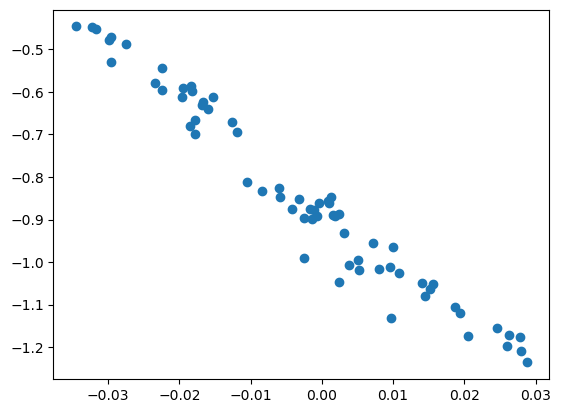

In [ ]:
plt.scatter(np.sum(s_e[:,:2], axis=1), s_e[:,3])
plt.show()

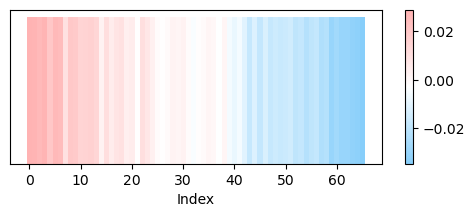

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# 假设 s_e 是一个已经定义好的二维数组
# s_e = ...

# 定义淡红色到白色到淡蓝色的颜色映射
colors = [(135/255,206/255,250/255), (1, 1, 1), (1, 0.7, 0.7)]  # R -> W -> B
n_bins = 100  # 颜色分段数量
cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# 调整图的大小并明确创建一个Axes实例
fig, ax = plt.subplots(figsize=(6, 2))

# 计算彩虹色值
rainbow_colors = np.sum(s_e[:, :2], axis=1)
normalized_colors = (rainbow_colors - min(rainbow_colors)) / (max(rainbow_colors) - min(rainbow_colors))  # 归一化颜色值

# 创建彩虹色条形图
bar_positions = np.arange(len(rainbow_colors))  # 条形图的位置
bar_width = 1.0  # 设定条形图的宽度

# 绘制条形图，高度为原始数据，指定颜色为自定义的彩虹色
bars = ax.bar(bar_positions, 1, width=bar_width, color=cm(normalized_colors))

# 创建一个ScalarMappable对象用于颜色条
sm = plt.cm.ScalarMappable(cmap=cm, norm=plt.Normalize(vmin=min(rainbow_colors), vmax=max(rainbow_colors)))
sm.set_array([])  # 只是为了满足函数要求，实际上不会使用到这个数组

# 添加颜色条并指定其关联的Axes
cbar = plt.colorbar(sm, ax=ax, orientation='vertical')

ax.set_xlabel('Index')
# ax.set_ylabel('Sum of First Two Columns')
# ax.set_title('Custom Rainbow Color Bar Chart Based on Original Data')
ax.yaxis.set_visible(False)  # 只关闭y轴
plt.show()


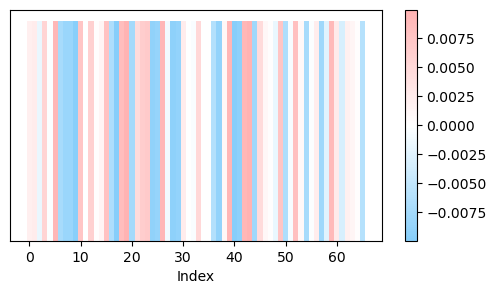

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# 假设 s_e 是一个已经定义好的二维数组
# s_e = ...

# 定义淡红色到白色到淡蓝色的颜色映射
colors = [(135/255,206/255,250/255), (1, 1, 1), (1, 0.7, 0.7)]  # R -> W -> B
n_bins = 100  # 颜色分段数量
cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# 调整图的大小并明确创建一个Axes实例
fig, ax = plt.subplots(figsize=(6, 3))

# 计算彩虹色值
rainbow_colors = s_e[:, 2]
normalized_colors = (rainbow_colors - min(rainbow_colors)) / (max(rainbow_colors) - min(rainbow_colors))  # 归一化颜色值

# 创建彩虹色条形图
bar_positions = np.arange(len(rainbow_colors))  # 条形图的位置
bar_width = 1.0  # 设定条形图的宽度

# 绘制条形图，高度为原始数据，指定颜色为自定义的彩虹色
bars = ax.bar(bar_positions, 1, width=bar_width, color=cm(normalized_colors))

# 创建一个ScalarMappable对象用于颜色条
sm = plt.cm.ScalarMappable(cmap=cm, norm=plt.Normalize(vmin=min(rainbow_colors), vmax=max(rainbow_colors)))
sm.set_array([])  # 只是为了满足函数要求，实际上不会使用到这个数组

# 添加颜色条并指定其关联的Axes
cbar = plt.colorbar(sm, ax=ax, orientation='vertical')

ax.set_xlabel('Index')
# ax.set_ylabel('Sum of First Two Columns')
# ax.set_title('Custom Rainbow Color Bar Chart Based on Original Data')
ax.yaxis.set_visible(False)  # 只关闭y轴
plt.show()


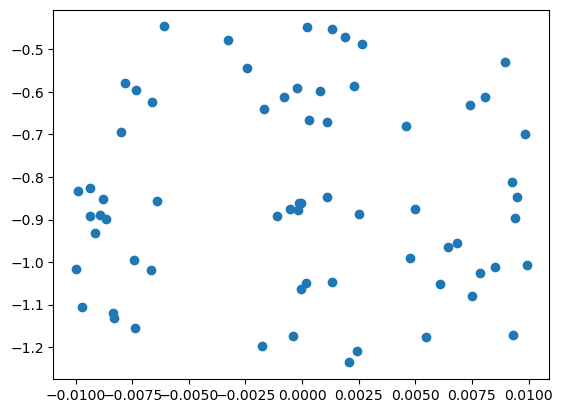

In [ ]:
plt.scatter(s_e[:,2], s_e[:,3])
plt.show()

In [ ]:
raise()

TypeError: exceptions must derive from BaseException

In [ ]:
for i in range(len(ml_GNN_data_d)):
    n = str(i + len(GNN_data_d0) + 1000)
    GNN_data_d[n] = ml_GNN_data_d[str(i + 1000)]
GNN_data_d.keys()  # 合并

dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020', '1021', '1022', '1023', '1024', '1025', '1026', '1027', '1028', '1029', '1030', '1031', '1032', '1033', '1034', '1035', '1036', '1037', '1038', '1039', '1040', '1041', '1042', '1043', '1044', '1045', '1046', '1047', '1048', '1049', '1050', '1051', '1052', '1053'])

In [ ]:
if istore:
    del_file(lmdb_file_all)
    del_file(f"{lmdb_file_all}-lock")

    del_file(lmdb_file_train)
    del_file(f"{lmdb_file_train}-lock")

    del_file(lmdb_file_test)
    del_file(f"{lmdb_file_test}-lock")

    db_all = lmdb.open(  # 整合的所有的数据
        lmdb_file_all,
        map_size=1024 * 1024 * 1024 * 2,
        subdir=False,
        meminit=False,
        map_async=True,
    )

    db_train = lmdb.open(  # 拆分的训练数据
        lmdb_file_train,
        map_size=1024 * 1024 * 1024 * 2,
        subdir=False,
        meminit=False,
        map_async=True,
    )

    db_test = lmdb.open(  # 拆分的测试数据
        lmdb_file_test,
        map_size=1024 * 1024 * 1024 * 2,
        subdir=False,
        meminit=False,
        map_async=True,
    )

The file /media/zwbai/DATA/dft/alloy_copy/output/CuO2_strain_all.lmdb was successfully deleted 
The file /media/zwbai/DATA/dft/alloy_copy/output/CuO2_strain_all.lmdb-lock was successfully deleted 
The file /media/zwbai/DATA/dft/alloy_copy/output/CuO2_strain_train.lmdb was successfully deleted 
The file /media/zwbai/DATA/dft/alloy_copy/output/CuO2_strain_train.lmdb-lock was successfully deleted 
The file /media/zwbai/DATA/dft/alloy_copy/output/CuO2_strain_test.lmdb was successfully deleted 
The file /media/zwbai/DATA/dft/alloy_copy/output/CuO2_strain_test.lmdb-lock was successfully deleted 


In [ ]:
if istore:
    idx = 0  # 数据库方式保存，可以执行机器学习
    for key, value in GNN_data_d.items():
        print(key)
        for value0 in value:
            value0.sid = idx
            # Write to LMDB
            txn = db_all.begin(write=True)
            txn.put(
                f"{idx}".encode("ascii"),
                pickle.dumps(value0, protocol=-1),
            )
            txn.commit()
            db_all.sync()
            print(idx)
            idx += 1
    db_all.close()

1000
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
1001
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
1002
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
1003
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
1004
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
1005
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
1006
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
1007
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
1008
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
1009
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
1010
250
251
252
253
254
255
256
257
258
259
260
261
262
263

In [ ]:
print("lmdb all file path:", lmdb_file_all)
all_dataset = LmdbDataset({"src": lmdb_file_all})

all_energies = [data.y_relaxed for data in all_dataset]
mean = np.mean(all_energies)
stdev = np.std(all_energies)
mean, stdev, len(all_energies)

lmdb all file path: /media/zwbai/DATA/dft/alloy_copy/output/CuO2_strain_all.lmdb


(-0.6934392287844889, 0.78421780482165, 1341)

In [ ]:
train_data, test_data = train_test_split(all_dataset, test_size=0.1)

In [ ]:
if istore:
    idx = 0
    for value in train_data:
        value.sid = idx
        # Write to LMDB
        txn_train = db_train.begin(write=True)
        txn_train.put(
            f"{idx}".encode("ascii"),
            pickle.dumps(value, protocol=-1),
        )
        txn_train.commit()
        db_train.sync()
        idx += 1
    db_train.close()

    idx = 0
    for value in test_data:
        value.sid = idx
        # Write to LMDB
        txn_test = db_test.begin(write=True)
        txn_test.put(
            f"{idx}".encode("ascii"),
            pickle.dumps(value, protocol=-1),
        )
        txn_test.commit()
        db_test.sync()
        idx += 1
    db_test.close()

In [ ]:
exist_folder(data_path, is_creat=True)
for file in pack_data_files:
    shutil.copy(file, data_path)  # copy file for further ML

folder '/media/zwbai/DATA/dft/alloy_copy/vasp_cal/' exists


In [ ]:
state_path = folder_path_all + "state.pkl"

In [ ]:
dill.dump_module(state_path)

TypeError: cannot pickle 'Environment' object

In [ ]:
raise

In [ ]:
dill.load_module(state_path)

# 6. predict the impact of 3d strain 

In [ ]:
max_strain = 0.02
strain_range = max_strain * 2
resolution = 0.005
strain_num = int(strain_range / resolution + 1)
pre_strain = np.zeros((strain_num, strain_num, strain_num, 3))
pre_strain.shape
for i in range(strain_num):
    for j in range(strain_num):
        for k in range(strain_num):
            strain = [i, j, k]
            strain = np.array(strain) * resolution - max_strain
            pre_strain[i, j, k] = strain

pre_strain[:, :, :, 2] = pre_strain[:, :, :, 2] / 2
pre_strain = pre_strain.reshape((1, -1, 3))
pre_strain = np.tile(pre_strain, (9, 1, 1))
pre_strain.shape

In [ ]:
ax = plt.subplot(projection="3d")  # 创建一个三维的绘图工程
ax.set_title("3d_image_show")  # 设置本图名称
ax.scatter(pre_strain[0, :, 0], pre_strain[0, :, 1], pre_strain[0, :, 2])

plt.show()

In [ ]:
pre_bulk_l, pre_bulk_d = get_bulk_set(bulk, pre_strain)  # bulk上施加应变

pre_slab_l0 = bulk2slab(pre_bulk_l)  # 生成表面
pre_slab_l, pre_slab_d = slab2slabs(pre_slab_l0)  # 拓展

sort_nei0 = [sort_nei_l[i] for i in range(len(sort_nei_l)) if i % 3 == 0]
sort_nei0

In [ ]:
pre_strain_adslab = get_strain_adslab(molecule_d, pre_slab_d, sort_nei0)
pre_strain_adslab_d = array2dict(pre_strain_adslab)
len(pre_strain_adslab), len(pre_strain_adslab[0])

In [ ]:
istore = False
if istore:  # need 16min
    pre_GNN_data_d = get_GNN_data(pre_strain_adslab_d)
    with open(pre_GNN_data_dict, "wb") as file:  # 字典形式保存，该格式方便合并
        pickle.dump(pre_GNN_data_d, file)
else:
    with open(pre_GNN_data_dict, "rb") as file:
        pre_GNN_data_d = pickle.load(file)

In [ ]:
if istore:
    del_file(lmdb_file_pre)
    del_file(f"{lmdb_file_pre}-lock")

    db_pre = lmdb.open(
        lmdb_file_pre,
        map_size=1024 * 1024 * 1024 * 2,
        subdir=False,
        meminit=False,
        map_async=True,
    )

In [ ]:
if istore:
    idx = 0  # 数据库方式保存，可以执行机器学习
    for key, value in pre_GNN_data_d.items():
        for value0 in value:
            value0.sid = idx
            txn = db_pre.begin(write=True)
            txn.put(
                f"{idx}".encode("ascii"),
                pickle.dumps(value0, protocol=-1),
            )
            txn.commit()
            db_pre.sync()
            print(idx)
            idx += 1
    db_pre.close()

In [ ]:
print("lmdb all file path:", lmdb_file_pre)
pre_dataset = LmdbDataset({"src": lmdb_file_pre})

all_energies = [data.y_relaxed for data in pre_dataset]
mean = np.mean(all_energies)
stdev = np.std(all_energies)
mean, stdev, len(all_energies)

In [ ]:
pre_path = (
    "/home/zwbai/work/ocp-main/ocp/results/2024-01-18-22-02-40/is2re_predictions.npz"
)

In [ ]:
_, pre_e = get_predata(lmdb_file_pre, pre_path)
pre_e = pre_e.reshape((9, strain_num, strain_num, strain_num))
pre_strain.shape, pre_e.shape

In [ ]:
pre_data = np.concatenate([pre_strain, pre_e.reshape(9, -1, 1)], axis=-1)
io.savemat("pre_data.mat", {"array": pre_data})

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# 生成随机的三维坐标和对应的数值
n = 100  # 点的数量
i = 8
xyz = pre_strain[i]  # 三维坐标
val = pre_e[i]  # 数值

# 创建一个三维的绘图工程
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
# ax.set_title("3d_image_show")

# 颜色映射
cmap = plt.cm.rainbow

# 绘制散点图
sc = ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=val, cmap=cmap)

# 添加颜色条
plt.colorbar(sc)
plt.show()

print(np.max(val) - np.min(val))

In [ ]:
for i in range(9):
    print(np.max(pre_e[i]) - np.min(pre_e[i]))

<a id='target_section2'></a>
### Anchor point to continue run code [2]